# Football Network 

In [8]:
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy
import xlsxwriter
import xlrd
import openpyxl

In [11]:
#import files players, teams, matches, events

raw_players = pd.read_csv('players.csv')
players = pd.DataFrame(data=raw_players )

worldcup_2018_matches = pd.read_excel('matches_teams_DMSN.xlsx')

with open("teams.json") as f:
    teams = pd.DataFrame(json.load(f))
    f.close() 
    
with open("matches_World_Cup.json") as f:
    matches = pd.DataFrame(json.load(f))
    f.close()
    
with open("events_World_Cup.json") as f:
    events = pd.DataFrame(json.load(f))
    f.close()


In [3]:
def create_and_show_graph(events,matchId, teamOneId,teamOneName, teamTwoId, teamTwoName):
    
    #Only interested in the events which happened in the Cup Final, with matchId 2058017.
    wc_final_events = events[events['matchId']==matchId]
    events = wc_final_events.reset_index(drop=True)
        
    #initialize the graph
    G = nx.Graph()
    teamColours = {teamOneId: 'red', teamTwoId: 'blue'}

    #Create Graph
    for i in range(len(events)-1):
        if (events['subEventName'][i]=="Simple pass" or events['subEventName'][i]=="High pass" ) and len(events['tags'][i])==1:
            n1, n2 = events['playerId'][i], events['playerId'][i+1]
            p1, p2 = list(players[players['wyId']==n1]['shortName'])[0], list(players[players['wyId']==n2]['shortName'])[0]
            t1, t2 = events['teamId'][i], events['teamId'][i+1]
            r1, r2 = list(players[players['wyId']==n1]['role/name'])[0], list(players[players['wyId']==n2]['role/name'])[0]
            t = events['tags'][i]
            if n1 not in G.nodes():
                G.add_node(n1, teamid=t1, role=r1, color=teamColours[t1], shortName=p1)
            if n2 not in G.nodes():
                G.add_node(n2, teamid=t2, role=r2, color=teamColours[t2], shortName=p2)
            if any([row['id']==1801 for row in t]):
                G.add_edge(n1,n2)
            
    #add graph node attributes
    player_information = {}

    for n in G.nodes():
        playerName = nx.get_node_attributes(G,'shortName')[n]
        playerRole = nx.get_node_attributes(G, 'role')[n]
        player_information[n] = (playerName + ' : ' + playerRole).encode().decode('unicode_escape')


    #Create graph nodes list
    teamOneNodes = [n for (n, team) in nx.get_node_attributes(G,"teamid").items() if team == teamOneId]
    teamTwoNodes = [n for (n, team) in nx.get_node_attributes(G,"teamid").items() if team == teamTwoId]

    matchDegree = nx.degree(G)
    #Show graph
    a4_dims = (20, 20)
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_axis_off()

    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=teamOneNodes, node_color='red', alpha=0.4, labels=player_information, with_labels=True, node_size=[v * 200 for v in dict(matchDegree).values()])
    nx.draw_networkx_nodes(G, pos, nodelist=teamTwoNodes, node_color='blue', alpha=0.4, labels=player_information, with_labels=True, node_size=[v * 200 for v in dict(matchDegree).values()])
    nx.draw_networkx_edges(G, pos, with_labels=True, alpha=0.2,width=3)
    nx.draw_networkx_labels(G, pos, labels= player_information, font_size=20)

    # create folder based on match
    
    rootPath= '/Users/Maneesha Majeed/DMSN_results/'
    folderName = teamOneName + ' vs ' + teamTwoName + ' matchId ' + str(matchId)
    _dir = os.path.join(rootPath, folderName)
    
    # create 'dynamic' dir, if it does not exist
    if not os.path.exists(_dir):
        os.makedirs(_dir)
    
    plt.savefig(_dir + '/match_graph.PNG')
    plt.title(teamOneName + ' vs ' + teamTwoName, fontsize=20)
#   plt.show()
    
    return {'graph':G, 'folderName': _dir}


In [20]:
def create_and_show_subgraph(G,nodeList,color,folderName,fileName):
    #get sub graph
    G_subGraph = G.subgraph(nodeList)

    #create nodelist
    player_information= {}
    for n in G.nodes():
        playerName = nx.get_node_attributes(G,'shortName')[n]
        playerRole = nx.get_node_attributes(G, 'role')[n]
        player_information[n] = (playerName + ' : ' + playerRole).encode().decode('unicode_escape')


    a4_dims = (15, 15)
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_axis_off()

    #get node for specific criteria
    g_labels = {node:player_information[node] for node in nodeList}

    #draw graph
    graph_degree = nx.degree(G)
    pos = nx.kamada_kawai_layout(G_subGraph)
    nx.draw_networkx_nodes(G_subGraph, pos, node_color=color, alpha=0.4, labels=player_information, with_labels=True, node_size=[v * 200 for v in dict(graph_degree).values()])
    nx.draw_networkx_edges(G_subGraph, pos, with_labels=True,alpha=0.2,width=3)
    nx.draw_networkx_labels(G_subGraph,pos, labels=g_labels, font_size=20)
    
    plt.savefig(folderName + '/'+ fileName)
#     plt.show()
    
    return G_subGraph

In [14]:
def calculate_graph_network_statistics(G):
    
    graph_degree = nx.degree(G) 
    graph_degree_dic = dict(graph_degree)
    sum_graph_degree=np.sum(list(graph_degree_dic.values()))
    average_nodedegree = sum_graph_degree/float(len(G.nodes()))
    
    cluster_coefficient = nx.average_clustering(G)
    connectivity = nx.algebraic_connectivity(G)
    density = nx.density(G)
    centrality =nx.global_reaching_centrality(G)
    
    return {'cluster_coefficient': cluster_coefficient,'average_nodedegree': average_nodedegree,
            'connectivity':connectivity,'density': density,'centrality':centrality}

        

In [ ]:
writer = pd.ExcelWriter('matches_teams_DMSN_output.xlsx',engine='xlsxwriter')

for index, match in worldcup_2018_matches.iterrows():
    
     # get match information from file
    matchId = match['matchId']
    teamName = match['Team']
    teamId = match['team_id']
    
    opponentName = match['Opponent']
    opponentId = match['opponent_id']
    
    #create match graph
    match_information = create_and_show_graph(events, matchId, teamId, teamName, opponentId, opponentName)
    match_graph = match_information['graph']
    folderName= match_information['folderName']

    #create team and opponent graph
    team = [n for (n, team) in nx.get_node_attributes(match_graph,"teamid").items() if team == teamId]
    opponent = [n for (n, team) in nx.get_node_attributes(match_graph,"teamid").items() if team == opponentId]
    team_graph = create_and_show_subgraph(match_graph,team, 'pink',folderName , (teamName +'_graph' ))
    opponent_graph =  create_and_show_subgraph(match_graph,opponent, 'green',folderName , (opponentName+'_graph'))

    #create team attack and defend graph
    team_attack_nodes = [n for (n, role) in nx.get_node_attributes(team_graph,"role").items() if role == 'Forward' or role == 'Midfielder']
    team_defend_nodes = [n for (n, role) in nx.get_node_attributes(team_graph,"role").items() if role == 'Defender' or  role == 'Goalkeeper']
    team_attack_graph = create_and_show_subgraph(team_graph ,team_attack_nodes, 'red',folderName,(teamName +'_attack_graph'))
    team_defend_graph = create_and_show_subgraph(team_graph ,team_defend_nodes, 'blue',folderName,(teamName +'_defend_graph'))

    #create opponent attack and defend graph
    opponent_attack_nodes = [n for (n, role) in nx.get_node_attributes(opponent_graph,"role").items() if role == 'Forward' or role == 'Midfielder']
    opponent_defend_nodes = [n for (n, role) in nx.get_node_attributes(opponent_graph,"role").items() if role == 'Defender' or  role == 'Goalkeeper']
    opponent_attack_graph = create_and_show_subgraph(opponent_graph ,opponent_attack_nodes, 'red',folderName,(opponentName +'_attack_graph'))
    opponent_defend_graph = create_and_show_subgraph(opponent_graph ,opponent_defend_nodes, 'blue',folderName,(opponentName +'_defend_graph'))
    
    #team attack network statistics 
    team_attack_statistics = calculate_graph_network_statistics(team_attack_graph)
      
    team_cluster = pd.DataFrame([team_attack_statistics['cluster_coefficient']])
    team_connectivity = pd.DataFrame([team_attack_statistics['connectivity']])
    team_average_nodedegree =pd.DataFrame([team_attack_statistics['average_nodedegree']])
    team_density=pd.DataFrame([team_attack_statistics['density']])
    team_centrality=pd.DataFrame([team_attack_statistics['centrality']])
   
    #write to excel columns
    team_cluster.to_excel(writer,startcol=17, startrow=index, header=None, index=False)
    team_connectivity.to_excel(writer,startcol=18, startrow=index, header=None, index=False)
    team_average_nodedegree.to_excel(writer,startcol=19, startrow=index, header=None, index=False)
    team_density.to_excel(writer,startcol=20, startrow=index, header=None, index=False)
    team_centrality.to_excel(writer,startcol=21, startrow=index, header=None, index=False)

    
    
    #opponent attack network statistics
    opponent_attack_statistics = calculate_graph_network_statistics(opponent_attack_graph)
    
    opponent_cluster = pd.DataFrame([opponent_attack_statistics['cluster_coefficient']])
    opponent_connectivity = pd.DataFrame([opponent_attack_statistics['connectivity']])
    opponent_average_nodedegree =pd.DataFrame([opponent_attack_statistics['average_nodedegree']])
    opponent_density=pd.DataFrame([opponent_attack_statistics['density']])
    opponent_centrality=pd.DataFrame([opponent_attack_statistics['centrality']])
    
    #write to excel columns
    opponent_cluster.to_excel(writer,startcol=10, startrow=index, header=None, index=False)
    opponent_connectivity.to_excel(writer,startcol=11, startrow=index, header=None, index=False)
    opponent_average_nodedegree.to_excel(writer,startcol=12, startrow=index, header=None, index=False)
    opponent_density.to_excel(writer,startcol=13, startrow=index, header=None, index=False)
    opponent_centrality.to_excel(writer,startcol=14, startrow=index, header=None, index=False)
    
    
writer.save()

print('DataFrame is written successfully to Excel File.')


# Results Analysis to calculate LucaBall score


In [6]:
#Uploading the results excel 
#results_raw = pd.read_excel('matches_teams_DMSN_Maneesha.xlsx')
results_raw = pd.read_excel('DMSN_football_LucaBall score_updated.xlsx')
results = pd.DataFrame(data=results_raw )
results


Game                     Group          Team      Opponent  Goals For  \
0       1                         A        Russia  Saudi Arabia          5   
1       1                         A  Saudi Arabia        Russia          0   
2       2                         A         Egypt       Uruguay          0   
3       2                         A       Uruguay         Egypt          1   
4       3                         B       Morocco       IR Iran          0   
..    ...                       ...           ...           ...        ...   
123    62               Semi-finals       England       Croatia          1   
124    63  Play-off for third place       Belgium       England          2   
125    63  Play-off for third place       England       Belgium          0   
126    64                     Final        France       Croatia          4   
127    64                     Final       Croatia        France          2   

     Goals Against  teams_attempts_on_target  opponent_attempts_on_target  \
0                0                         7                            0   
1                5                         0                            7   
2                1                         3                            4   
3                0                         4                            3   
4                1                         3                            2   
..             ...                       ...                          ...   
123              2                         1                            7   
124              0                         4                            5   
125              2                         5                            4   
126              2                         6                            3   
127              4                         3                            6   

     matchId  team_id  ...  opponent_attack_connectivity  \
0    2057954    14358  ...                      0.000000   
1    2057954    16521  ...                      3.236109   
2    2057955    16129  ...                      1.907576   
3    2057955    15670  ...                      1.657077   
4    2057961    16216  ...                      0.916128   
..       ...      ...  ...                           ...   
123  2058015     2413  ...                      0.000000   
124  2058016     5629  ...                      3.438447   
125  2058016     2413  ...                      3.000000   
126  2058017     4418  ...                      1.000000   
127  2058017     9598  ...                      1.906549   

     opponent_attack_average_nodedegree  opponent_attack_density  \
0                              3.555556                 0.444444   
1                              7.000000                 0.777778   
2                              6.000000                 0.750000   
3                              5.111111                 0.638889   
4                              4.000000                 0.571429   
..                                  ...                      ...   
123                            4.500000                 0.642857   
124                            5.750000                 0.821429   
125                            5.750000                 0.821429   
126                            5.000000                 0.714286   
127                            4.666667                 0.583333   

     opponent_attack_centrality  team_attack_cluster_coefficient  \
0                      0.265625                         0.819286   
1                      0.148148                         0.674074   
2                      0.156250                         0.814550   
3                      0.234375                         0.867196   
4                      0.197279                         0.773810   
..                          ...                              ...   
123                    0.183673                         0.654167   
124                    0.102041                         0.850

In [7]:
#To take the count of WDL 
print(results['WDL'].value_counts())
print(results.shape)
print(results.info())


W    55
L    55
D    18
Name: WDL, dtype: int64
(128, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 22 columns):
Game                                   128 non-null int64
Group                                  128 non-null object
Team                                   128 non-null object
Opponent                               128 non-null object
Goals For                              128 non-null int64
Goals Against                          128 non-null int64
teams_attempts_on_target               128 non-null int64
opponent_attempts_on_target            128 non-null int64
matchId                                128 non-null int64
team_id                                128 non-null int64
opponent_id                            128 non-null int64
opponent_attack_cluster_coefficient    128 non-null float64
opponent_attack_connectivity           128 non-null float64
opponent_attack_average_nodedegree     128 non-null float64
opponent_attack_

In [8]:
#To remove all the draw matches
results = results[results['WDL'] != 'D']

#To get the data for win matches 
results_win=results.loc[results['WDL']=='W']

print(results_win['teams_attempts_on_target'].sum())
print(results_win['opponent_attempts_on_target'].sum())


#To get the data for loss matches
results_loss=results.loc[results['WDL']=='L']
print(results_loss['teams_attempts_on_target'].sum())
print(results_loss['opponent_attempts_on_target'].sum())

250
180
180
250


In [9]:
#Select the required columns to calculate the network statistics
results_cal =results[[ 'Game','Group','Team', 'Opponent', 'Goals For', 'Goals Against','matchId',
                       'teams_attempts_on_target', 'opponent_attempts_on_target',
                      'opponent_attack_cluster_coefficient','opponent_attack_connectivity', 'opponent_attack_average_nodedegree',
       'opponent_attack_density','opponent_attack_centrality','team_attack_centrality',
        'team_attack_cluster_coefficient','team_attack_connectivity', 'team_attack_average_nodedegree','team_attack_density',
                      'WDL']]
results_cal

Game                     Group          Team      Opponent  Goals For  \
0       1                         A        Russia  Saudi Arabia          5   
1       1                         A  Saudi Arabia        Russia          0   
2       2                         A         Egypt       Uruguay          0   
3       2                         A       Uruguay         Egypt          1   
4       3                         B       Morocco       IR Iran          0   
..    ...                       ...           ...           ...        ...   
123    62               Semi-finals       England       Croatia          1   
124    63  Play-off for third place       Belgium       England          2   
125    63  Play-off for third place       England       Belgium          0   
126    64                     Final        France       Croatia          4   
127    64                     Final       Croatia        France          2   

     Goals Against  matchId  teams_attempts_on_target  \
0                0  2057954                         7   
1                5  2057954                         0   
2                1  2057955                         3   
3                0  2057955                         4   
4                1  2057961                         3   
..             ...      ...                       ...   
123              2  2058015                         1   
124              0  2058016                         4   
125              2  2058016                         5   
126              2  2058017                         6   
127              4  2058017                         3   

     opponent_attempts_on_target  opponent_attack_cluster_coefficient  \
0                              0                             0.674074   
1                              7                             0.819286   
2                              4                             0.867196   
3                              3                             0.814550   
4                              2                             0.554167   
..                           ...                                  ...   
123                            7                             0.775000   
124                            5                             0.873810   
125                            4                             0.850000   
126                            3                             0.736310   
127                            6                             0.724339   

     opponent_attack_connectivity  opponent_attack_average_nodedegree  \
0                        0.000000                            3.555556   
1                        3.236109                            7.000000   
2                        1.907576                            6.000000   
3                        1.657077                            5.111111   
4                        0.916128                            4.000000   
..                            ...                                 ...   
123                      0.000000                            4.500000   
124                      3.438447                            5.750000   
125                      3.000000                            5.750000   
126                      1.000000                            5.000000   
127                      1.906549                            4.666667   

     opponent_attack_density  opponent_attack_centrality  \
0                   0.444444                    0.265625   
1                   0.777778                    0.148148   
2                   0.750000                    0.156250   
3                   0.638889                    0.234375   
4                   0.571429                    0.197279   
..                       ...                         ...   
123                 0.642857                    0.183673   
124                 0.821429                    0.102041   
125                 0.821429                    0.142857   
126                 0.714286 

### Attack statistics

In [10]:
#Attack cluster coefficient
results_cal[['team_attack_cluster_coefficient','team_attack_connectivity','team_attack_density','team_attack_centrality','team_attack_average_nodedegree','teams_attempts_on_target']].describe()

team_attack_cluster_coefficient  team_attack_connectivity  \
count                       110.000000                110.000000   
mean                          0.759595                  1.618915   
std                           0.104387                  1.103473   
min                           0.322222                  0.000000   
25%                           0.703175                  0.884717   
50%                           0.778274                  1.790706   
75%                           0.838095                  2.378643   
max                           0.952381                  5.000000   

       team_attack_density  team_attack_centrality  \
count           110.000000              110.000000   
mean              0.662439                0.173550   
std               0.112502                0.045996   
min               0.266667                0.027778   
25%               0.607143                0.142857   
50%               0.666667                0.171875   
75%               0.722222                0.204082   
max               1.000000                0.278646   

       team_attack_average_nodedegree  teams_attempts_on_target  
count                      110.000000                110.000000  
mean                         4.893506                  3.909091  
std                          0.882473                  2.320809  
min                          2.400000                  0.000000  
25%                          4.444444                  2.000000  
50%                          4.888889                  3.000000  
75%                          5.541667                  5.000000  
max                          7.111111                 12.000000

In [11]:
#Normalized Data
cols_to_norm = ['teams_attempts_on_target', 'opponent_attempts_on_target',
                'team_attack_connectivity','opponent_attack_connectivity', 
               'team_attack_average_nodedegree', 'opponent_attack_average_nodedegree']
results_cal[cols_to_norm] = results_cal[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [12]:
results_cal['team_attack_cluster_coefficient'].value_counts(bins=5)

(0.7, 0.826]      52
(0.826, 0.952]    31
(0.574, 0.7]      20
(0.448, 0.574]     5
(0.321, 0.448]     2
Name: team_attack_cluster_coefficient, dtype: int64

In [13]:
#To find the matches with tie for metric score
results_cal.loc[results_cal['teams_attempts_on_target'] == results_cal['opponent_attempts_on_target']]

Game        Group        Team    Opponent  Goals For  Goals Against  \
14     8            D     Croatia     Nigeria          2              0   
15     8            D     Nigeria     Croatia          0              2   
16     9            E  Costa Rica      Serbia          0              1   
17     9            E      Serbia  Costa Rica          1              0   
96    49  Round of 16      France   Argentina          4              3   
97    49  Round of 16   Argentina      France          3              4   

    matchId  teams_attempts_on_target  opponent_attempts_on_target  \
14  2057973                  0.166667                     0.166667   
15  2057973                  0.166667                     0.166667   
16  2057979                  0.250000                     0.250000   
17  2057979                  0.250000                     0.250000   
96  2058003                  0.333333                     0.333333   
97  2058003                  0.333333                     0.333333   

    opponent_attack_cluster_coefficient  opponent_attack_connectivity  \
14                             0.625926                      0.000000   
15                             0.803968                      0.434315   
16                             0.695833                      0.166558   
17                             0.753571                      0.200000   
96                             0.819048                      0.326270   
97                             0.544444                      0.083415   

    opponent_attack_average_nodedegree  opponent_attack_density  \
14                            0.245283                 0.444444   
15                            0.669811                 0.694444   
16                            0.498821                 0.678571   
17                            0.392689                 0.607143   
96                            0.278976                 0.619048   
97                            0.386792                 0.527778   

    opponent_attack_centrality  team_attack_centrality  \
14                    0.231771                0.171875   
15                    0.171875                0.231771   
16                    0.142857                0.244898   
17                    0.244898                0.142857   
96                    0.222222                0.164062   
97                    0.164062                0.222222   

    team_attack_cluster_coefficient  team_attack_connectivity  \
14                         0.803968                  0.434315   
15                         0.625926                  0.000000   
16                         0.753571                  0.200000   
17                         0.695833                  0.166558   
96                         0.544444                  0.083415   
97                         0.819048                  0.326270   

    team_attack_average_nodedegree  team_attack_density WDL  
14                        0.669811             0.694444   W  
15                        0.245283             0.444444   L  
16                        0.392689             0.607143   L  
17                        0.498821             0.678571   W  
96                        0.386792             0.527778   W  
97                        0.278976             0.619048   L

In [14]:
results_cal.loc[results_cal['team_attack_connectivity'] == results_cal['opponent_attack_connectivity']]

Game Group     Team Opponent  Goals For  Goals Against  matchId  \
26    14     G  Tunisia  England          1              2  2057991   
27    14     G  England  Tunisia          2              1  2057991   
56    29     F  Germany   Sweden          2              1  2057986   
57    29     F   Sweden  Germany          1              2  2057986   

    teams_attempts_on_target  opponent_attempts_on_target  \
26                  0.083333                     0.583333   
27                  0.583333                     0.083333   
56                  0.416667                     0.500000   
57                  0.500000                     0.416667   

    opponent_attack_cluster_coefficient  opponent_attack_connectivity  \
26                             0.575000                           0.0   
27                             0.808333                           0.0   
56                             0.322222                           0.0   
57                             0.741270                           0.0   

    opponent_attack_average_nodedegree  opponent_attack_density  \
26                            0.127358                 0.428571   
27                            0.392689                 0.607143   
56                            0.009434                 0.305556   
57                            0.433962                 0.555556   

    opponent_attack_centrality  team_attack_centrality  \
26                    0.251701                0.204082   
27                    0.204082                0.251701   
56                    0.278646                0.250000   
57                    0.250000                0.278646   

    team_attack_cluster_coefficient  team_attack_connectivity  \
26                         0.808333                       0.0   
27                         0.575000                       0.0   
56                         0.741270                       0.0   
57                         0.322222                       0.0   

    team_attack_average_nodedegree  team_attack_density WDL  
26                        0.392689             0.607143   L  
27                        0.127358             0.428571   W  
56                        0.433962             0.555556   W  
57                        0.009434             0.305556   L

In [15]:
results_cal.loc[results_cal['team_attack_average_nodedegree'] == results_cal['opponent_attack_average_nodedegree']]

Game                     Group     Team Opponent  Goals For  \
124    63  Play-off for third place  Belgium  England          2   
125    63  Play-off for third place  England  Belgium          0   

     Goals Against  matchId  teams_attempts_on_target  \
124              0  2058016                  0.333333   
125              2  2058016                  0.416667   

     opponent_attempts_on_target  opponent_attack_cluster_coefficient  \
124                     0.416667                              0.87381   
125                     0.333333                              0.85000   

     opponent_attack_connectivity  opponent_attack_average_nodedegree  \
124                      0.687689                            0.711085   
125                      0.600000                            0.711085   

     opponent_attack_density  opponent_attack_centrality  \
124                 0.821429                    0.102041   
125                 0.821429                    0.142857   

     team_attack_centrality  team_attack_cluster_coefficient  \
124                0.142857                          0.85000   
125                0.102041                          0.87381   

     team_attack_connectivity  team_attack_average_nodedegree  \
124                  0.600000                        0.711085   
125                  0.687689                        0.711085   

     team_attack_density WDL  
124             0.821429   W  
125             0.821429   L

In [16]:
results_cal.loc[results_cal['team_attack_density'] == results_cal['opponent_attack_density']]

Game                     Group     Team Opponent  Goals For  \
124    63  Play-off for third place  Belgium  England          2   
125    63  Play-off for third place  England  Belgium          0   

     Goals Against  matchId  teams_attempts_on_target  \
124              0  2058016                  0.333333   
125              2  2058016                  0.416667   

     opponent_attempts_on_target  opponent_attack_cluster_coefficient  \
124                     0.416667                              0.87381   
125                     0.333333                              0.85000   

     opponent_attack_connectivity  opponent_attack_average_nodedegree  \
124                      0.687689                            0.711085   
125                      0.600000                            0.711085   

     opponent_attack_density  opponent_attack_centrality  \
124                 0.821429                    0.102041   
125                 0.821429                    0.142857   

     team_attack_centrality  team_attack_cluster_coefficient  \
124                0.142857                          0.85000   
125                0.102041                          0.87381   

     team_attack_connectivity  team_attack_average_nodedegree  \
124                  0.600000                        0.711085   
125                  0.687689                        0.711085   

     team_attack_density WDL  
124             0.821429   W  
125             0.821429   L

In [17]:
results_cal.loc[results_cal['team_attack_cluster_coefficient'] == results_cal['opponent_attack_cluster_coefficient']]

Empty DataFrame
Columns: [Game, Group, Team, Opponent, Goals For, Goals Against, matchId, teams_attempts_on_target, opponent_attempts_on_target, opponent_attack_cluster_coefficient, opponent_attack_connectivity, opponent_attack_average_nodedegree, opponent_attack_density, opponent_attack_centrality, team_attack_centrality, team_attack_cluster_coefficient, team_attack_connectivity, team_attack_average_nodedegree, team_attack_density, WDL]
Index: []

In [18]:
results_cal.loc[results_cal['team_attack_centrality'] == results_cal['opponent_attack_centrality']]

Empty DataFrame
Columns: [Game, Group, Team, Opponent, Goals For, Goals Against, matchId, teams_attempts_on_target, opponent_attempts_on_target, opponent_attack_cluster_coefficient, opponent_attack_connectivity, opponent_attack_average_nodedegree, opponent_attack_density, opponent_attack_centrality, team_attack_centrality, team_attack_cluster_coefficient, team_attack_connectivity, team_attack_average_nodedegree, team_attack_density, WDL]
Index: []

In [19]:
#Attack
results_cal['attack_cluster_coefficient'] = np.where(results_cal['team_attack_cluster_coefficient'] >results_cal['opponent_attack_cluster_coefficient'], 1,0)
results_cal['attack_attempts_on_target']=  np.where(results_cal['teams_attempts_on_target'] >results_cal['opponent_attempts_on_target'], 1,0)
results_cal['attack_connectivity'] = np.where((results_cal['team_attack_connectivity'] >=results_cal['opponent_attack_connectivity']),1,0)
results_cal['attack_average_nodedegree'] = np.where(results_cal['team_attack_average_nodedegree'] >= results_cal['opponent_attack_average_nodedegree'], 1,0)
results_cal['attack_density'] = np.where(results_cal['team_attack_density'] >= results_cal['opponent_attack_density'], 1,0)
results_cal['attack_centrality'] = np.where(results_cal['team_attack_centrality'] < results_cal['opponent_attack_centrality'],1,0)
results_cal

Game                     Group          Team      Opponent  Goals For  \
0       1                         A        Russia  Saudi Arabia          5   
1       1                         A  Saudi Arabia        Russia          0   
2       2                         A         Egypt       Uruguay          0   
3       2                         A       Uruguay         Egypt          1   
4       3                         B       Morocco       IR Iran          0   
..    ...                       ...           ...           ...        ...   
123    62               Semi-finals       England       Croatia          1   
124    63  Play-off for third place       Belgium       England          2   
125    63  Play-off for third place       England       Belgium          0   
126    64                     Final        France       Croatia          4   
127    64                     Final       Croatia        France          2   

     Goals Against  matchId  teams_attempts_on_target  \
0                0  2057954                  0.583333   
1                5  2057954                  0.000000   
2                1  2057955                  0.250000   
3                0  2057955                  0.333333   
4                1  2057961                  0.250000   
..             ...      ...                       ...   
123              2  2058015                  0.083333   
124              0  2058016                  0.333333   
125              2  2058016                  0.416667   
126              2  2058017                  0.500000   
127              4  2058017                  0.250000   

     opponent_attempts_on_target  opponent_attack_cluster_coefficient  ...  \
0                       0.000000                             0.674074  ...   
1                       0.583333                             0.819286  ...   
2                       0.333333                             0.867196  ...   
3                       0.250000                             0.814550  ...   
4                       0.166667                             0.554167  ...   
..                           ...                                  ...  ...   
123                     0.583333                             0.775000  ...   
124                     0.416667                             0.873810  ...   
125                     0.333333                             0.850000  ...   
126                     0.250000                             0.736310  ...   
127                     0.500000                             0.724339  ...   

     team_attack_connectivity  team_attack_average_nodedegree  \
0                    0.647222                        0.976415   
1                    0.000000                        0.245283   
2                    0.331415                        0.575472   
3                    0.381515                        0.764151   
4                    0.193785                        0.764151   
..                        ...                             ...   
123                  0.138760                        0.339623   
124                  0.600000                        0.711085   
125                  0.687689                        0.711085   
126                  0.381310                        0.481132   
127                  0.200000                        0.551887   

     team_attack_density  WDL  attack_cluster_coefficient  \
0               0.777778    W                           1   
1               0.444444    L                           0   
2               0.638889    L                           0   
3               0.750000    W                           1   
4               0.666667    L                           1   
..                   ...  ...                         ...   
123             0.571429    L                           0   
124             0.821429    W                           0   
125             0.821429    L                           1   
126             0.583333    W                          

In [20]:
#Calculating LucaBall score(attack stats)
results_cal['attack_stats'] =  results_cal[['attack_average_nodedegree','attack_cluster_coefficient',
                                            'attack_connectivity','attack_centrality','attack_density']].sum(axis=1)

results_cal['attack_stats_total'] = np.where(results_cal['attack_stats'] >=2.5, 1,0)


In [21]:
print(results_cal.groupby(['WDL'])['attack_stats_total'].value_counts())
print(results_cal.groupby(['WDL'])['attack_stats'].value_counts())

WDL  attack_stats_total
L    0                     30
     1                     25
W    1                     30
     0                     25
Name: attack_stats_total, dtype: int64
WDL  attack_stats
L    0               13
     1               11
     5               11
     3                8
     2                6
     4                6
W    5               14
     4               10
     0                9
     2                9
     1                7
     3                6
Name: attack_stats, dtype: int64


In [22]:
#To calculate the total attack stats with respect to W and L
print(results_cal.groupby(['WDL'])['attack_stats'].sum())


WDL
L    126
W    153
Name: attack_stats, dtype: int64


In [23]:
results_cal.groupby(['attack_stats','attack_attempts_on_target'])['WDL'].value_counts()

attack_stats  attack_attempts_on_target  WDL
0             0                          L      11
                                         W       3
              1                          W       6
                                         L       2
1             0                          L       8
                                         W       4
              1                          L       3
                                         W       3
2             0                          W       7
                                         L       4
              1                          L       2
                                         W       2
3             0                          L       3
                                         W       3
              1                          L       5
                                         W       3
4             0                          L       2
                                         W       2
              1                      

In [24]:
print("Attempts on Target")
print(results_cal.groupby(['WDL'])['attack_attempts_on_target'].value_counts())
print("Attack Density")
print(results_cal.groupby(['WDL'])['attack_density'].value_counts())
print("Attack Clustering coefficient")
print(results_cal.groupby(['WDL'])['attack_cluster_coefficient'].value_counts())
print("Attack average Node degree")
print(results_cal.groupby(['WDL'])['attack_average_nodedegree'].value_counts())
print("Attack Centrality")
print(results_cal.groupby(['WDL'])['attack_centrality'].value_counts())
print("Attack Connectivity")
print(results_cal.groupby(['WDL'])['attack_connectivity'].value_counts())

Attempts on Target
WDL  attack_attempts_on_target
L    0                            35
     1                            20
W    1                            32
     0                            23
Name: attack_attempts_on_target, dtype: int64
Attack Density
WDL  attack_density
L    0                 32
     1                 23
W    1                 33
     0                 22
Name: attack_density, dtype: int64
Attack Clustering coefficient
WDL  attack_cluster_coefficient
L    1                             29
     0                             26
W    0                             29
     1                             26
Name: attack_cluster_coefficient, dtype: int64
Attack average Node degree
WDL  attack_average_nodedegree
L    0                            31
     1                            24
W    1                            32
     0                            23
Name: attack_average_nodedegree, dtype: int64
Attack Centrality
WDL  attack_centrality
L    0                    32

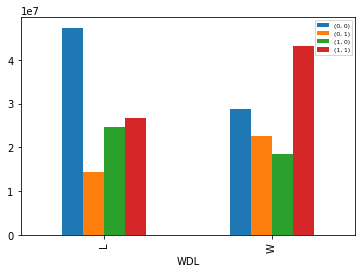

In [25]:
pd.pivot_table(results_cal, values = 'matchId', index = 'WDL', 
               columns = ['attack_stats_total','attack_attempts_on_target'],
               aggfunc = lambda x: sum(x)).plot.bar()
plt.legend(loc='upper right',fontsize=6)

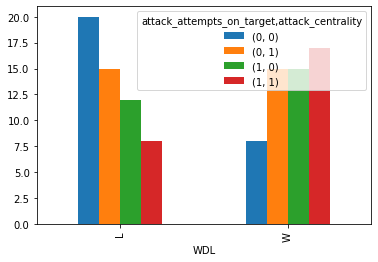

In [26]:
pd.pivot_table(results_cal, values = 'matchId', index = 'WDL', 
               columns = ['attack_attempts_on_target','attack_centrality'],
               aggfunc = lambda x: len(x)).plot.bar()

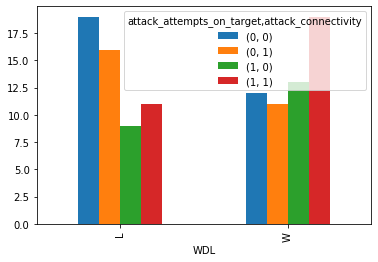

In [27]:
pd.pivot_table(results_cal, values = 'matchId', index = 'WDL', columns =['attack_attempts_on_target' ,'attack_connectivity'],
               aggfunc = lambda x: len(x)).plot.bar()

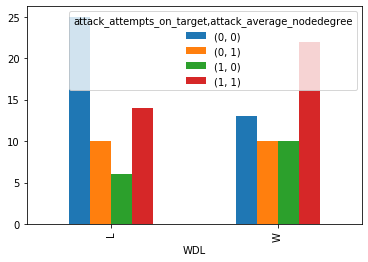

In [28]:
pd.pivot_table(results_cal, values = 'matchId', index = 'WDL', columns = ['attack_attempts_on_target','attack_average_nodedegree'],
               aggfunc = lambda x: len(x)).plot.bar()

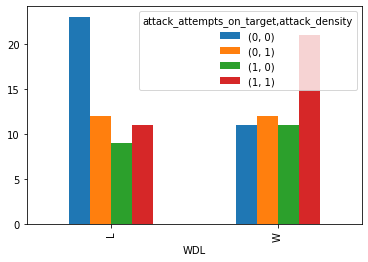

In [29]:
pd.pivot_table(results_cal, values = 'matchId', index = 'WDL', columns =['attack_attempts_on_target', 'attack_density'],
               aggfunc = lambda x: len(x)).plot.bar()

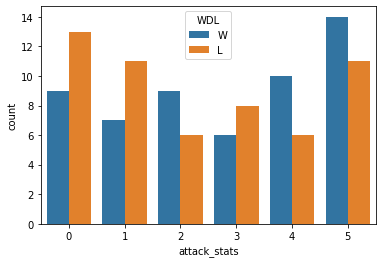

In [30]:

sns.countplot(data=results_cal[['teams_attempts_on_target','attack_stats','WDL']],x='attack_stats',hue='WDL')


In [31]:
#To get the data for win matches 
results_win=results_cal.loc[results_cal['WDL']=='W']
print(results_win['attack_stats'].value_counts())
print(results_win['attack_stats'].sum())
print(results_win['teams_attempts_on_target'].sum())
print(results_win['opponent_attempts_on_target'].sum())
print(results_win.groupby(['WDL'])['attack_attempts_on_target'].sum())


#To get the data for loss matches
results_loss=results_cal.loc[results_cal['WDL']=='L']
print(results_loss['attack_stats'].value_counts())
print(results_loss['attack_stats'].sum())
print(results_loss.groupby(['WDL'])['attack_attempts_on_target'].sum())


5    14
4    10
2     9
0     9
1     7
3     6
Name: attack_stats, dtype: int64
153
20.833333333333336
15.000000000000002
WDL
W    32
Name: attack_attempts_on_target, dtype: int32
0    13
5    11
1    11
3     8
4     6
2     6
Name: attack_stats, dtype: int64
126
WDL
L    20
Name: attack_attempts_on_target, dtype: int32


### Teams Analysis

In [32]:
#Results group stage 
results_groupstage=results_cal[0:77]
results_teamscore=pd.DataFrame(results_groupstage.groupby(['Team'])['attack_stats'].sum())
#results_teamscore.sort_values(ascending=False)

results_groupstage_teams=results_groupstage.groupby(['Team'])['attack_stats'].sum()
# list= results_roundof16['Team'].unique()
#print(results_teamscore)
print(results_groupstage_teams.sort_values(ascending=False))


Team
Croatia           14
Tunisia           14
Uruguay           13
Russia            11
Colombia          11
Korea Republic    11
Germany           10
Peru              10
Brazil            10
Mexico             9
Morocco            8
Serbia             8
France             7
Japan              7
England            7
Poland             6
Argentina          6
Belgium            5
Iceland            4
Saudi Arabia       4
Spain              3
Denmark            2
Costa Rica         2
IR Iran            2
Egypt              2
Portugal           2
Sweden             1
Nigeria            1
Panama             1
Australia          1
Senegal            1
Switzerland        0
Name: attack_stats, dtype: int64


In [33]:
#Results round of 16
results_roundof16=results_cal[78:94]
results_teams_roundof16=results_roundof16.groupby(['Team'])['attack_stats'].sum()
results_teams_roundof16.sort_values(ascending=False)




Team
Spain          5
Mexico         5
Denmark        5
Belgium        5
Colombia       4
Uruguay        3
Switzerland    3
Argentina      3
Sweden         2
Portugal       2
France         2
England        1
Russia         0
Japan          0
Croatia        0
Brazil         0
Name: attack_stats, dtype: int64

In [34]:
#Results quarter finals
results_quarterfinals=results_cal[95:102]
results_teams_quarterfinals=results_quarterfinals.groupby(['Team'])['attack_stats'].sum()
results_teams_quarterfinals.sort_values(ascending=False)


Team
England    4
Croatia    3
Brazil     3
Russia     2
France     2
Belgium    2
Sweden     1
Name: attack_stats, dtype: int64

In [35]:
#Results Semifinals and finals
results_semifinals=results_cal[102:110]
results_teams_semifinals=results_semifinals.groupby(['Team'])['attack_stats'].sum()
results_teams_semifinals.sort_values(ascending=False)

Team
Croatia    7
England    6
Belgium    6
France     3
Name: attack_stats, dtype: int64

In [36]:
#Knock out stage 
results_knockout=results_cal[78:110]
results_teams_knockout=results_knockout.groupby(['Team'])['attack_stats'].sum()
results_teams_knockout.sort_values(ascending=False)



Team
Belgium        13
England        11
Croatia        10
France          7
Uruguay         6
Spain           5
Mexico          5
Denmark         5
Colombia        4
Switzerland     3
Sweden          3
Brazil          3
Argentina       3
Russia          2
Portugal        2
Japan           0
Name: attack_stats, dtype: int64

In [37]:
#winning teams 
results_win=results_cal.loc[results_cal['WDL']=='W']
results_teams_win=results_win.groupby(['Team'])['attack_stats'].sum()
results_teams_win.sort_values(ascending=False)


Team
Croatia           21
Belgium           18
Uruguay           16
France            14
England           11
Brazil            10
Russia            10
Colombia           9
Germany            5
Argentina          5
Peru               4
Tunisia            4
Mexico             4
Japan              3
Saudi Arabia       3
Serbia             3
Spain              3
Portugal           2
Denmark            2
Sweden             2
Poland             1
Nigeria            1
Korea Republic     1
Senegal            1
IR Iran            0
Switzerland        0
Name: attack_stats, dtype: int64

### France and  Croatia  - Final teams

In [38]:
#France
results_france=results_cal.loc[results_cal['Team']== 'France']
results_france[['WDL','Group','Team','Opponent','matchId','attack_stats','teams_attempts_on_target','team_attack_density',
                'team_attack_cluster_coefficient','team_attack_average_nodedegree','team_attack_connectivity']]

WDL           Group    Team   Opponent  matchId  attack_stats  \
8     W               C  France  Australia  2057966             5   
42    W               C  France       Peru  2057968             2   
96    W     Round of 16  France  Argentina  2058003             2   
113   W  Quarter-finals  France    Uruguay  2058010             2   
120   W     Semi-finals  France    Belgium  2058014             1   
126   W           Final  France    Croatia  2058017             2   

     teams_attempts_on_target  team_attack_density  \
8                    0.416667             0.611111   
42                   0.333333             0.714286   
96                   0.333333             0.527778   
113                  0.166667             0.500000   
120                  0.416667             0.642857   
126                  0.500000             0.583333   

     team_attack_cluster_coefficient  team_attack_average_nodedegree  \
8                           0.813492                        0.528302   
42                          0.687500                        0.551887   
96                          0.544444                        0.386792   
113                         0.616931                        0.339623   
120                         0.766667                        0.445755   
126                         0.724339                        0.481132   

     team_attack_connectivity  
8                    0.389025  
42                   0.436870  
96                   0.083415  
113                  0.171989  
120                  0.189618  
126                  0.381310

In [39]:
#Croatia
results_croatia=results_cal.loc[results_cal['Team']== 'Croatia']
results_croatia[['WDL','Group','Team','Opponent','attack_stats','matchId','teams_attempts_on_target','team_attack_density',
                'team_attack_cluster_coefficient','team_attack_average_nodedegree','team_attack_connectivity']]

WDL           Group     Team   Opponent  attack_stats  matchId  \
14    W               D  Croatia    Nigeria             5  2057973   
45    W               D  Croatia  Argentina             4  2057974   
79    W               D  Croatia    Iceland             5  2057977   
102   W     Round of 16  Croatia    Denmark             0  2058005   
119   W  Quarter-finals  Croatia     Russia             3  2058012   
122   W     Semi-finals  Croatia    England             4  2058015   
127   L           Final  Croatia     France             3  2058017   

     teams_attempts_on_target  team_attack_density  \
14                   0.166667             0.694444   
45                   0.416667             0.642857   
79                   0.166667             0.750000   
102                  0.583333             0.638889   
119                  0.250000             0.678571   
122                  0.583333             0.642857   
127                  0.250000             0.714286   

     team_attack_cluster_coefficient  team_attack_average_nodedegree  \
14                          0.803968                        0.669811   
45                          0.669643                        0.445755   
79                          0.841667                        0.604953   
102                         0.735714                        0.575472   
119                         0.771429                        0.498821   
122                         0.775000                        0.445755   
127                         0.736310                        0.551887   

     team_attack_connectivity  
14                   0.434315  
45                   0.517157  
79                   0.546237  
102                  0.500443  
119                  0.471499  
122                  0.000000  
127                  0.200000

# Match Analysis

### Spain vs Russia

In [40]:
#Spain vs Russia
results_spain=results_cal.loc[results_cal['matchId']== 2058004]
results_spain[['WDL','Group','Team','Opponent','matchId','teams_attempts_on_target','team_attack_density','attack_stats','WDL',
                'team_attack_cluster_coefficient','team_attack_average_nodedegree','team_attack_connectivity','team_attack_centrality']]

WDL        Group    Team Opponent  matchId  teams_attempts_on_target  \
100   L  Round of 16   Spain   Russia  2058004                  0.750000   
101   W  Round of 16  Russia    Spain  2058004                  0.083333   

     team_attack_density  attack_stats WDL  team_attack_cluster_coefficient  \
100             0.833333             5   L                         0.838624   
101             0.500000             0   W                         0.771958   

     team_attack_average_nodedegree  team_attack_connectivity  \
100                        0.905660                  0.550537   
101                        0.339623                  0.246652   

     team_attack_centrality  
100                0.156250  
101                0.221354

### Mexico vs Germany

In [41]:
#Matches 1 mexico vs germany 2057984
results_mexico=results_cal.loc[results_cal['matchId']== 2057984]
results_mexico[['WDL','Group','Team','Opponent','matchId','teams_attempts_on_target','attack_stats','opponent_attempts_on_target','team_attack_connectivity',
                'opponent_attack_centrality','team_attack_centrality','opponent_attack_density','team_attack_density',
                'team_attack_average_nodedegree','opponent_attack_average_nodedegree']]

WDL Group     Team Opponent  matchId  teams_attempts_on_target  \
18   L     F  Germany   Mexico  2057984                  0.750000   
19   W     F   Mexico  Germany  2057984                  0.333333   

    attack_stats  opponent_attempts_on_target  team_attack_connectivity  \
18             1                     0.333333                  0.171989   
19             4                     0.750000                  0.400000   

    opponent_attack_centrality  team_attack_centrality  \
18                    0.138889                0.153646   
19                    0.153646                0.138889   

    opponent_attack_density  team_attack_density  \
18                 0.809524             0.611111   
19                 0.611111             0.809524   

    team_attack_average_nodedegree  opponent_attack_average_nodedegree  
18                        0.528302                            0.521563  
19                        0.521563                            0.528302

### Argentina vs Croatia

In [42]:
# match 3 argentina vs croatia 2057974
results_croatia=results_cal.loc[results_cal['matchId']== 2057974]
results_croatia[['WDL','Group','Team','Opponent','matchId','teams_attempts_on_target','team_attack_density',
                'team_attack_cluster_coefficient','team_attack_average_nodedegree','team_attack_connectivity']]

WDL Group       Team   Opponent  matchId  teams_attempts_on_target  \
44   L     D  Argentina    Croatia  2057974                  0.250000   
45   W     D    Croatia  Argentina  2057974                  0.416667   

    team_attack_density  team_attack_cluster_coefficient  \
44             0.555556                         0.664550   
45             0.642857                         0.669643   

    team_attack_average_nodedegree  team_attack_connectivity  
44                        0.433962                  0.343854  
45                        0.445755                  0.517157

### Belgium vs Brazil

In [43]:
#match 2 belgium vs brazil 2058011
results_belgiumvsbrazil=results_cal.loc[results_cal['matchId']== 2058011]
results_belgiumvsbrazil[['WDL','Group','Team','Opponent','matchId','teams_attempts_on_target','team_attack_density',
                'team_attack_cluster_coefficient','team_attack_average_nodedegree','team_attack_connectivity']]

WDL           Group     Team Opponent  matchId  teams_attempts_on_target  \
114   L  Quarter-finals   Brazil  Belgium  2058011                      0.75   
115   W  Quarter-finals  Belgium   Brazil  2058011                      0.25   

     team_attack_density  team_attack_cluster_coefficient  \
114             0.694444                         0.822487   
115             0.761905                         0.757143   

     team_attack_average_nodedegree  team_attack_connectivity  
114                        0.669811                  0.521208  
115                        0.460916                  0.200000

### Belgium vs Japan

In [44]:

#match 2 belgium vs japan 2058007
results_belgiumvsjapan=results_cal.loc[results_cal['matchId']== 2058007]
results_belgiumvsjapan[['WDL','Group','Team','Opponent','matchId','teams_attempts_on_target','team_attack_density',
                'team_attack_cluster_coefficient','team_attack_average_nodedegree','team_attack_connectivity']]

WDL        Group     Team Opponent  matchId  teams_attempts_on_target  \
106   W  Round of 16  Belgium    Japan  2058007                  0.666667   
107   L  Round of 16    Japan  Belgium  2058007                  0.333333   

     team_attack_density  team_attack_cluster_coefficient  \
106             0.750000                         0.875000   
107             0.714286                         0.842857   

     team_attack_average_nodedegree  team_attack_connectivity  
106                        0.604953                       0.6  
107                        0.551887                       0.4

## Russia vs Saudi arabia

In [45]:

results_russia=results_cal.loc[results_cal['matchId']== 2057954]
results_russia[['WDL','Group','Team','Opponent','matchId','teams_attempts_on_target','team_attack_density','attack_stats','WDL',
                'team_attack_cluster_coefficient','team_attack_average_nodedegree','team_attack_connectivity','team_attack_centrality']]

WDL Group          Team      Opponent  matchId  teams_attempts_on_target  \
0   W     A        Russia  Saudi Arabia  2057954                  0.583333   
1   L     A  Saudi Arabia        Russia  2057954                  0.000000   

   team_attack_density  attack_stats WDL  team_attack_cluster_coefficient  \
0             0.777778             5   W                         0.819286   
1             0.444444             0   L                         0.674074   

   team_attack_average_nodedegree  team_attack_connectivity  \
0                        0.976415                  0.647222   
1                        0.245283                  0.000000   

   team_attack_centrality  
0                0.148148  
1                0.265625

### Semi Finals

In [46]:
#Semi Finals
results_semifinals=results_cal.loc[results_cal['Group']== 'Semi-finals']
results_semifinals[['WDL','Group','Team','Opponent','matchId','teams_attempts_on_target','team_attack_density','attack_stats',
                'team_attack_cluster_coefficient','team_attack_average_nodedegree','team_attack_connectivity']]

WDL        Group     Team Opponent  matchId  teams_attempts_on_target  \
120   W  Semi-finals   France  Belgium  2058014                  0.416667   
121   L  Semi-finals  Belgium   France  2058014                  0.250000   
122   W  Semi-finals  Croatia  England  2058015                  0.583333   
123   L  Semi-finals  England  Croatia  2058015                  0.083333   

     team_attack_density  attack_stats  team_attack_cluster_coefficient  \
120             0.642857             1                         0.766667   
121             0.666667             4                         0.838095   
122             0.642857             4                         0.775000   
123             0.571429             1                         0.654167   

     team_attack_average_nodedegree  team_attack_connectivity  
120                        0.445755                  0.189618  
121                        0.622642                  0.400000  
122                        0.445755                  0.000000  
123                        0.339623                  0.138760

### Quarter Finals

In [47]:
#Quarter Finals
results_quarterfinals=results_cal.loc[results_cal['Group']== 'Quarter-finals']
results_quarterfinals[['WDL','Group','Team','Opponent','matchId','teams_attempts_on_target','team_attack_density','attack_stats',
                'team_attack_cluster_coefficient','team_attack_average_nodedegree','team_attack_connectivity','team_attack_centrality']]

WDL           Group     Team Opponent  matchId  teams_attempts_on_target  \
112   L  Quarter-finals  Uruguay   France  2058010                  0.333333   
113   W  Quarter-finals   France  Uruguay  2058010                  0.166667   
114   L  Quarter-finals   Brazil  Belgium  2058011                  0.750000   
115   W  Quarter-finals  Belgium   Brazil  2058011                  0.250000   
116   L  Quarter-finals   Sweden  England  2058013                  0.250000   
117   W  Quarter-finals  England   Sweden  2058013                  0.166667   
118   L  Quarter-finals   Russia  Croatia  2058012                  0.583333   
119   W  Quarter-finals  Croatia   Russia  2058012                  0.250000   

     team_attack_density  attack_stats  team_attack_cluster_coefficient  \
112             0.622222             3                         0.747143   
113             0.500000             2                         0.616931   
114             0.694444             3                         0.822487   
115             0.761905             2                         0.757143   
116             0.571429             1                         0.704762   
117             0.619048             4                         0.657143   
118             0.600000             2                         0.740476   
119             0.678571             3                         0.771429   

     team_attack_average_nodedegree  team_attack_connectivity  \
112                        0.679245                  0.000000   
113                        0.339623                  0.171989   
114                        0.669811                  0.521208   
115                        0.460916                  0.200000   
116                        0.218329                  0.000000   
117                        0.278976                  0.184970   
118                        0.636792                  0.415106   
119                        0.498821                  0.471499   

     team_attack_centrality  
112                0.222222  
113                0.216146  
114                0.171875  
115                0.166667  
116                0.250000  
117                0.162037  
118                0.164609  
119                0.183673

####  Correlation

In [48]:
results_corr=results_cal.copy()

In [49]:
results_corr

Game                     Group          Team      Opponent  Goals For  \
0       1                         A        Russia  Saudi Arabia          5   
1       1                         A  Saudi Arabia        Russia          0   
2       2                         A         Egypt       Uruguay          0   
3       2                         A       Uruguay         Egypt          1   
4       3                         B       Morocco       IR Iran          0   
..    ...                       ...           ...           ...        ...   
123    62               Semi-finals       England       Croatia          1   
124    63  Play-off for third place       Belgium       England          2   
125    63  Play-off for third place       England       Belgium          0   
126    64                     Final        France       Croatia          4   
127    64                     Final       Croatia        France          2   

     Goals Against  matchId  teams_attempts_on_target  \
0                0  2057954                  0.583333   
1                5  2057954                  0.000000   
2                1  2057955                  0.250000   
3                0  2057955                  0.333333   
4                1  2057961                  0.250000   
..             ...      ...                       ...   
123              2  2058015                  0.083333   
124              0  2058016                  0.333333   
125              2  2058016                  0.416667   
126              2  2058017                  0.500000   
127              4  2058017                  0.250000   

     opponent_attempts_on_target  opponent_attack_cluster_coefficient  ...  \
0                       0.000000                             0.674074  ...   
1                       0.583333                             0.819286  ...   
2                       0.333333                             0.867196  ...   
3                       0.250000                             0.814550  ...   
4                       0.166667                             0.554167  ...   
..                           ...                                  ...  ...   
123                     0.583333                             0.775000  ...   
124                     0.416667                             0.873810  ...   
125                     0.333333                             0.850000  ...   
126                     0.250000                             0.736310  ...   
127                     0.500000                             0.724339  ...   

     team_attack_density  WDL  attack_cluster_coefficient  \
0               0.777778    W                           1   
1               0.444444    L                           0   
2               0.638889    L                           0   
3               0.750000    W                           1   
4               0.666667    L                           1   
..                   ...  ...                         ...   
123             0.571429    L                           0   
124             0.821429    W                           0   
125             0.821429    L                           1   
126             0.583333    W                           0   
127             0.714286    L                           1   

     attack_attempts_on_target  attack_connectivity  \
0                            1                    1   
1                            0                    0   
2                            0                    0   
3                            1                    1   
4                            1                    1   
..                         ...                  ...   
123                          0                    1   
124                          0                    0   
125                          1                    1   
126                          1                    1   
127                          0                    0   

     attack_average_nodedegree  attack_density  atta

In [50]:
#replace wdl to 1 and 0 
results_corr['WDL']=results_corr['WDL'].replace({'W': 1, 'L': 0})
results_corr['WDL']

0      1
1      0
2      0
3      1
4      0
      ..
123    0
124    1
125    0
126    1
127    0
Name: WDL, Length: 110, dtype: int64

AxesSubplot(0.125,0.125;0.62x0.755)
                                         Game  Goals For  Goals Against  \
Game                                 1.000000   0.089601       0.089601   
Goals For                            0.089601   1.000000      -0.164863   
Goals Against                        0.089601  -0.164863       1.000000   
matchId                              0.791897   0.118145       0.118145   
teams_attempts_on_target             0.124051   0.480742      -0.167930   
opponent_attempts_on_target          0.124051  -0.167930       0.480742   
opponent_attack_cluster_coefficient  0.086699  -0.035146       0.052393   
opponent_attack_connectivity         0.061260  -0.094012       0.141067   
opponent_attack_average_nodedegree  -0.021654  -0.217156       0.140567   
opponent_attack_density              0.097386  -0.145513       0.136758   
opponent_attack_centrality          -0.095915   0.144626      -0.080334   
team_attack_centrality              -0.095915  -0.080334       0

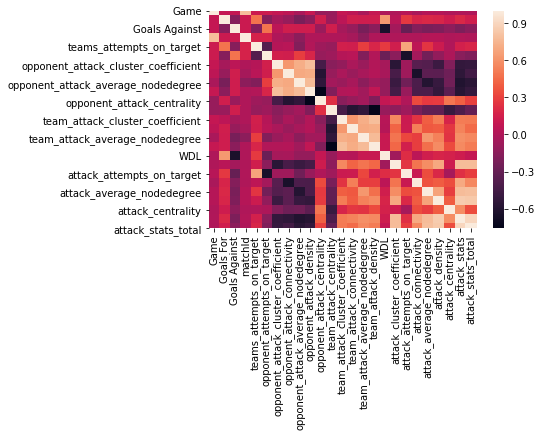

In [51]:
print(sns.heatmap(results_corr.corr()))
print(results_corr.corr())

                                      WDL  Goals For  \
WDL                              1.000000   0.631384   
Goals For                        0.631384   1.000000   
teams_attempts_on_target         0.275454   0.480742   
team_attack_density              0.106174   0.136758   
team_attack_cluster_coefficient  0.032965   0.052393   
attack_connectivity              0.054582   0.181167   
team_attack_average_nodedegree   0.104703   0.140567   
team_attack_centrality          -0.089267  -0.080334   
attack_stats                     0.132523   0.198374   

                                 teams_attempts_on_target  \
WDL                                              0.275454   
Goals For                                        0.480742   
teams_attempts_on_target                         1.000000   
team_attack_density                              0.187282   
team_attack_cluster_coefficient                  0.148285   
attack_connectivity                              0.064434   
team_attack_

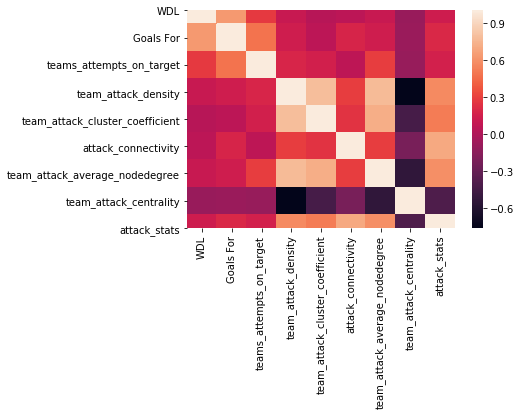

In [52]:
#to get the correlation 
results_attack=results_corr[['WDL','Goals For','teams_attempts_on_target','team_attack_density','team_attack_cluster_coefficient','attack_connectivity',
                           'team_attack_average_nodedegree','team_attack_centrality','attack_stats']]
print(results_attack.corr())
print(sns.heatmap(results_attack.corr()))


In [53]:

#To find the correlation between columns

x = results_corr['teams_attempts_on_target']
y = results_corr['Goals For']

print(scipy.stats.pearsonr(x, y))

'''Here I can see both: the correlation - which is really strong and then the p-value, which indicates that
this is statistically significant.'''

(0.4807420216982694, 1.0631887739434051e-07)


'Here I can see both: the correlation - which is really strong and then the p-value, which indicates that\nthis is statistically significant.'

In [54]:
x = results_corr['teams_attempts_on_target']
y = results_corr['team_attack_connectivity']

print(scipy.stats.pearsonr(x, y))

(0.14347778252755317, 0.13481896693134096)


In [55]:
x = results_corr['teams_attempts_on_target']
y = results_corr['team_attack_average_nodedegree']

print(scipy.stats.pearsonr(x, y))

(0.2914794610431048, 0.002004816937374133)


In [56]:
x = results_corr['attack_attempts_on_target']
y = results_corr['attack_cluster_coefficient']

print(scipy.stats.pearsonr(x, y))

(0.2549249642552304, 0.007194797832501885)


In [57]:
x = results_corr['teams_attempts_on_target']
y = results_corr['WDL']

print(scipy.stats.pearsonr(x, y))

(0.27545395961026536, 0.0035849215055747557)


In [58]:
x = results_corr['teams_attempts_on_target']
y = results_corr['team_attack_centrality']

print(scipy.stats.pearsonr(x, y))

(-0.0989038128412263, 0.3039567917819576)


# PART 2  

### England vs Belgium

Number of nodes in this random graph : 28
Number of edges in this random graph : 168
Clustering Coefficient: 0.665539 
Name: 
Type: Graph
Number of nodes: 28
Number of edges: 168
Average degree:  12.0000


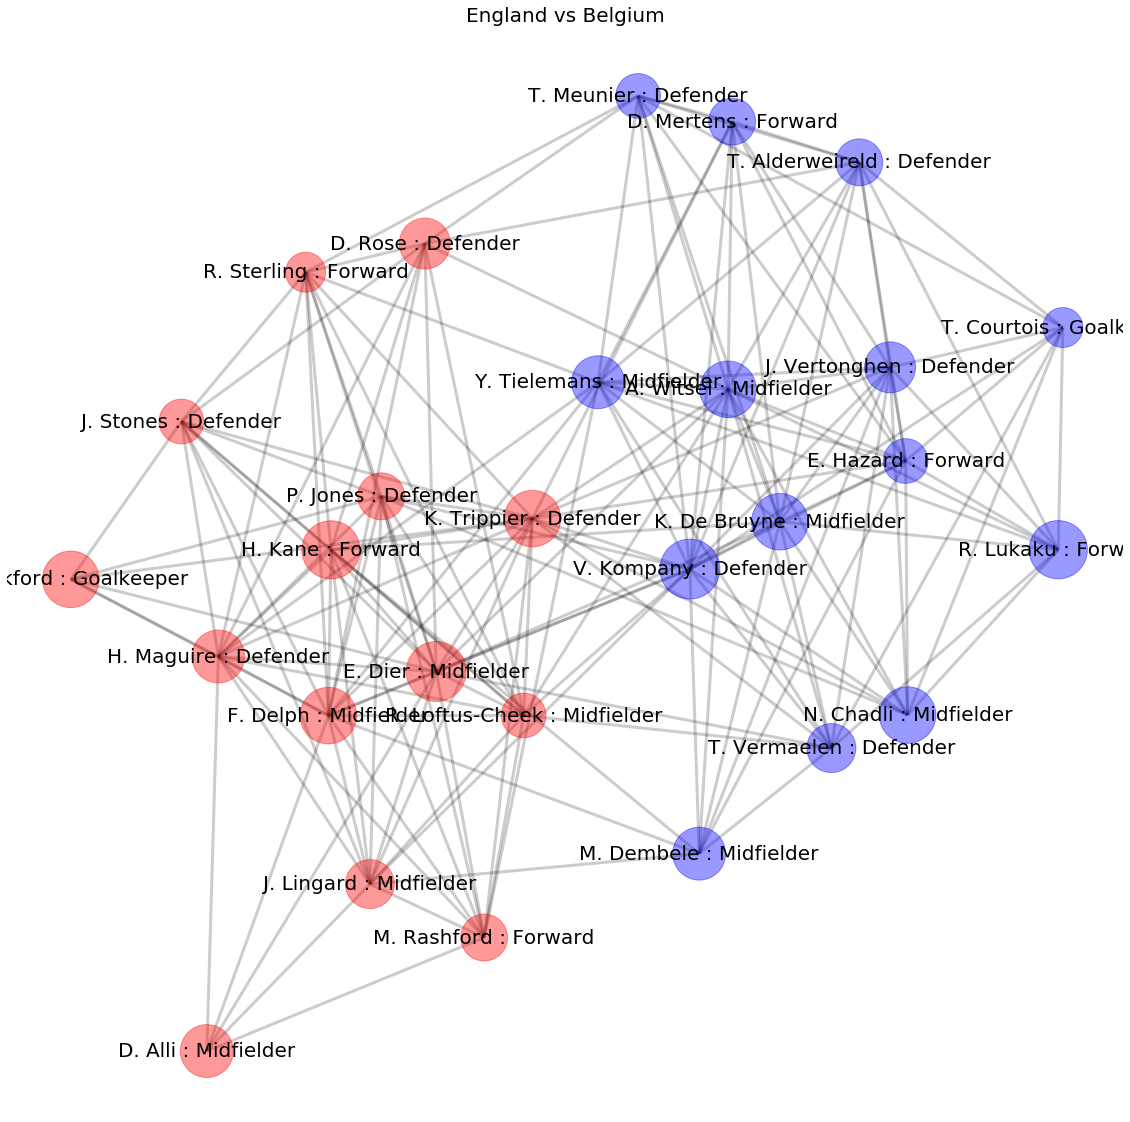

In [59]:
#To get a match graph of England vs Belgium
EngvsBel =create_and_show_graph(events,2058016, 2413,'England', 5629, 'Belgium')

print("Number of nodes in this random graph :" ,EngvsBel['graph'].number_of_nodes())
print("Number of edges in this random graph :" ,EngvsBel['graph'].number_of_edges())
print("Clustering Coefficient: %f "%nx.average_clustering(EngvsBel['graph']))
print(nx.info(EngvsBel['graph']))

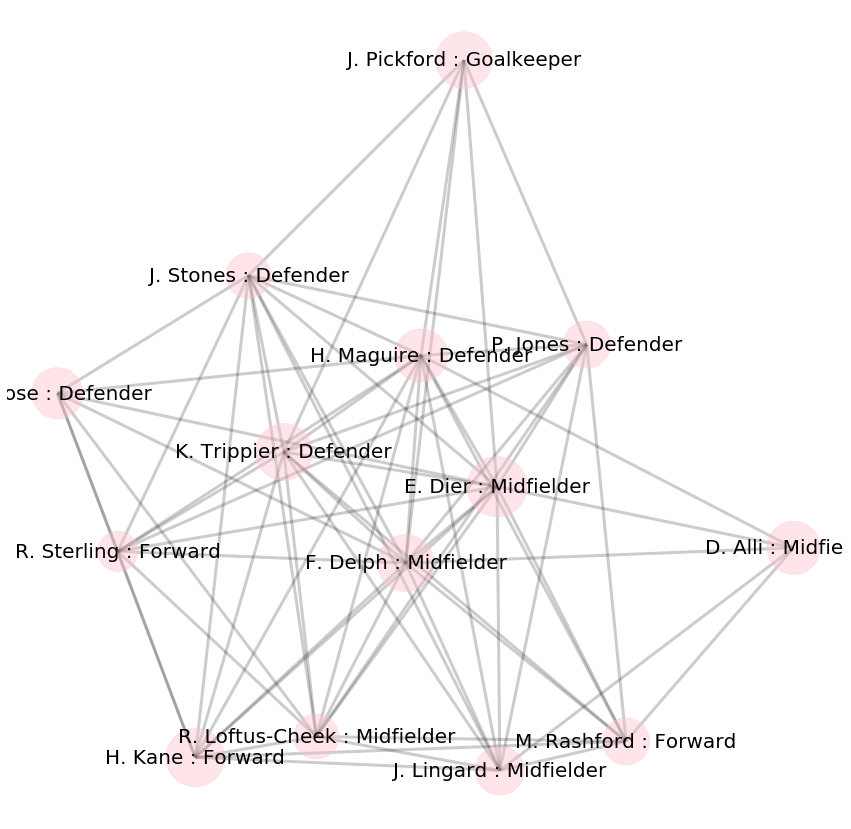

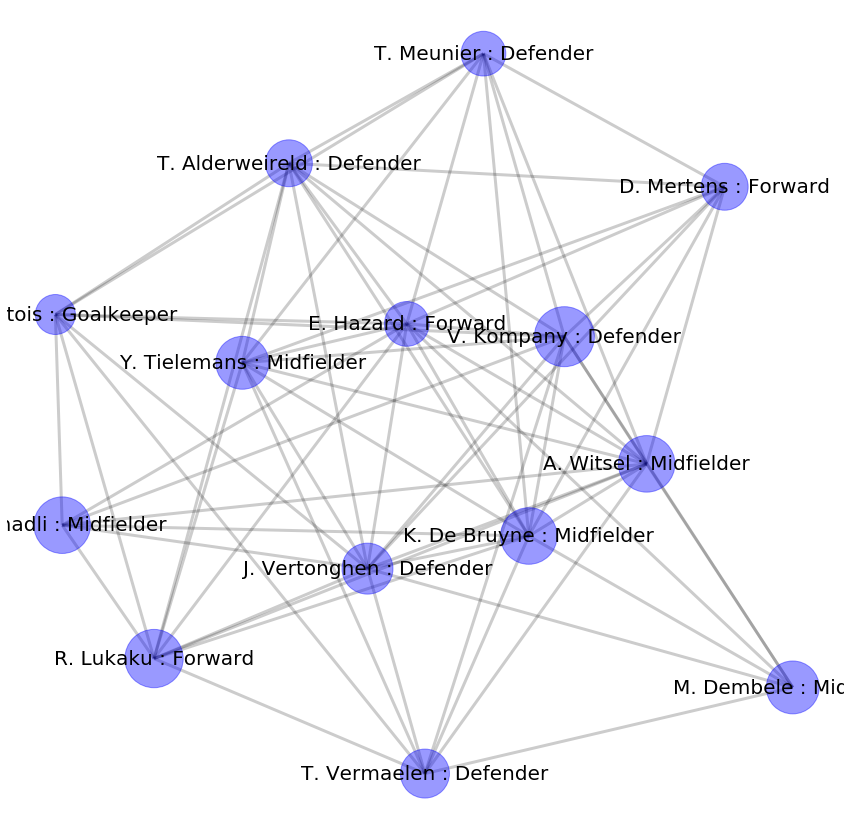

In [60]:
#TO get the individual attack graph of team and opponet in a match 
eng=[n for (n,team) in nx.get_node_attributes(EngvsBel['graph'],"teamid").items() if team == 2413]
bel=[n for (n,team) in nx.get_node_attributes(EngvsBel['graph'],"teamid").items() if team == 5629]

#To create and show subgraph for england and belgium
eng_graph=create_and_show_subgraph(EngvsBel['graph'],eng,'pink','/Users/Maneesha Majeed/DMSN_results/',('England'+ '_graph'))
bel_graph=create_and_show_subgraph(EngvsBel['graph'],bel,'blue','/Users/Maneesha Majeed/DMSN_results/',('Belgium'+ '_graph'))

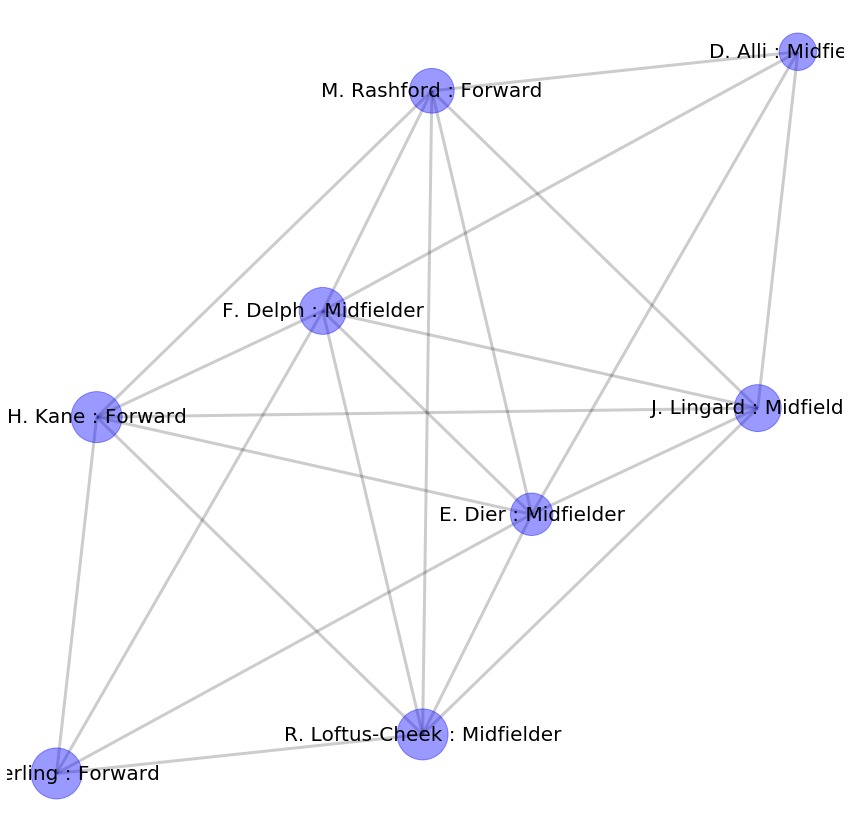

In [61]:
#To create adn show subgraph for england and belgium attack graph


#create team attack graph England
eng_attack_nodes = [n for (n, role) in nx.get_node_attributes(eng_graph,"role").items() if role == 'Forward' or role == 'Midfielder']
eng_attack_graph = create_and_show_subgraph(eng_graph ,eng_attack_nodes, 'blue','/Users/Maneesha Majeed/DMSN_results/',('England' +'_attack_graph'))




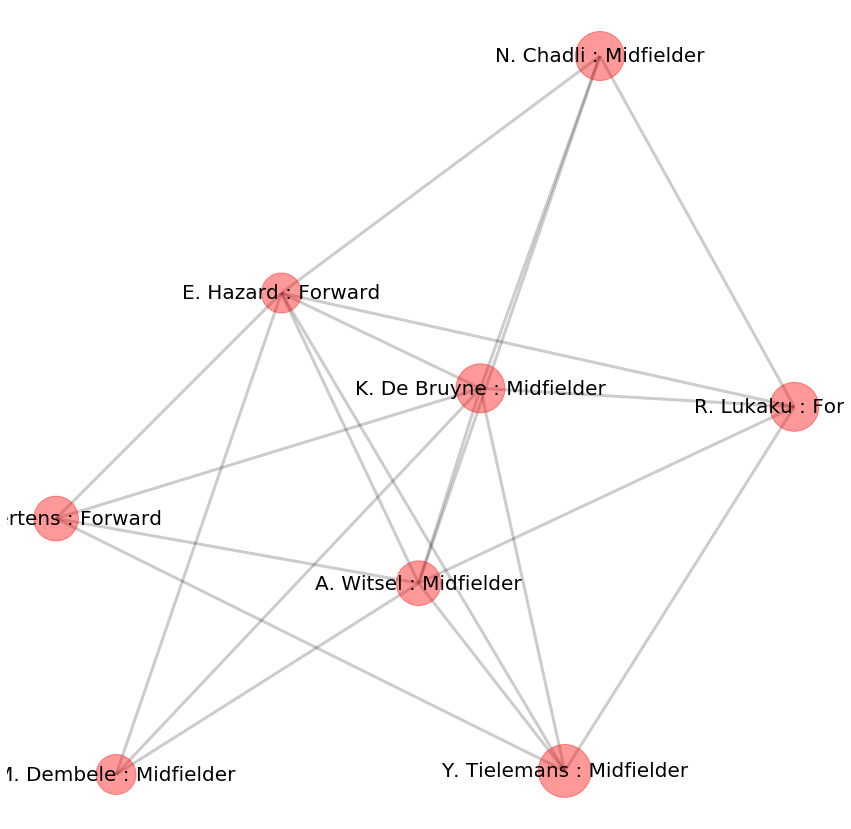

In [62]:
#create opponent attack  graph - Belgium
bel_attack_nodes = [n for (n, role) in nx.get_node_attributes(bel_graph,"role").items() if role == 'Forward' or role == 'Midfielder']
bel_attack_graph = create_and_show_subgraph(bel_graph ,bel_attack_nodes, 'red','/Users/Maneesha Majeed/DMSN_results/',('Belgium' +'_attack_graph'))

    

In [63]:
#eng_attack_graph 
graph_degree = nx.degree(eng_attack_graph) 
graph_degree_dic = dict(graph_degree)
sum_graph_degree=np.sum(list(graph_degree_dic.values()))
average_nodedegree = (sum_graph_degree)/float(len(eng_attack_graph.nodes()))

print("average_nodedegree=",average_nodedegree)
print("cluster_coefficient =", nx.average_clustering(eng_attack_graph))
print("connectivity =",nx.algebraic_connectivity(eng_attack_graph))
print("density =" ,nx.density(eng_attack_graph))
print("centrality = ",nx.global_reaching_centrality(eng_attack_graph))
print("bet_centrality=",nx.betweenness_centrality(eng_attack_graph))
    


average_nodedegree= 5.75
cluster_coefficient = 0.8738095238095238
connectivity = 3.4384471871911697
density = 0.8214285714285714
centrality =  0.1020408163265306
bet_centrality= {235555: 0.023809523809523808, 13484: 0.0, 8717: 0.023809523809523808, 397178: 0.023809523809523808, 8464: 0.07142857142857142, 11066: 0.0, 210044: 0.07142857142857142, 7934: 0.023809523809523808}


In [64]:
#To get the number of nodes and edges 
print(eng_attack_graph.number_of_nodes())
print(eng_attack_graph.number_of_edges())
print(bel_attack_graph.number_of_nodes())
print(bel_attack_graph.number_of_edges())
print(nx.info(eng_attack_graph))

8
23
8
23
Name: 
Type: Graph
Number of nodes: 8
Number of edges: 23
Average degree:   5.7500


In [65]:
graph_degree=nx.degree(eng_attack_graph)
graph_degree_dic=dict(graph_degree)
#np.mean(list(graph_degree_dictionary.values())
print(float(len(eng_attack_graph.nodes())))
print(list(graph_degree_dic.values()))
print(np.sum(list(graph_degree_dic.values()))/float(len(eng_attack_graph.nodes())))

8.0
[6, 4, 6, 6, 7, 4, 7, 6]
5.75


In [66]:
graph_degree = nx.degree(eng_attack_graph) 
graph_degree_dic = dict(graph_degree)
average_nodedegreee = np.sum(list(graph_degree_dic.values()))/float(len(eng_attack_graph.nodes()))
average_nodedegreee

5.75

### Degree based statistics = England vs Belgium 


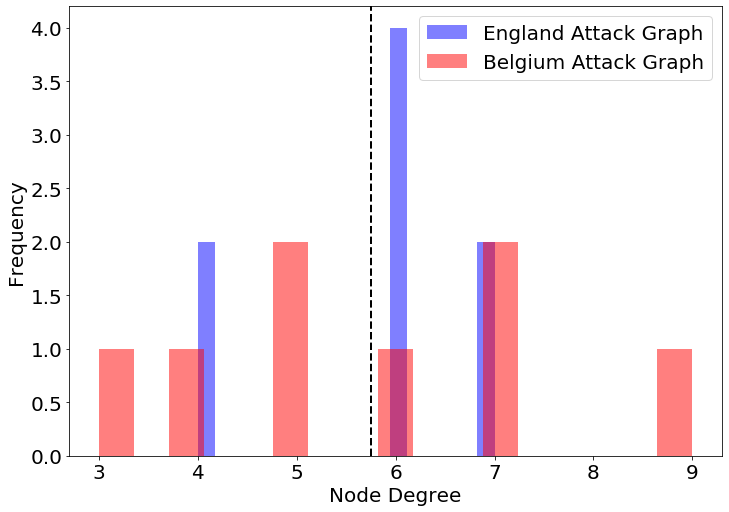

In [67]:
#eng_attack_graph
#bel_attack_graph

no_nodes = len(eng_attack_graph.nodes())
no_edges = len(eng_attack_graph.edges())

degrees_E = [d for n, d in eng_attack_graph.degree()]
degrees_B = [d for n, d in bel_attack_graph.degree()]

avg_deg = 2.0 * no_edges/no_nodes

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel('Node Degree',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.tick_params(labelsize=20)

plt.axvline(x=avg_deg, linewidth=2, linestyle='--', color='black')

plt.hist(degrees_E,bins=17,label="England Attack Graph",alpha=0.5,color='blue')
plt.hist(degrees_B,bins=17,label='Belgium Attack Graph',alpha=0.5,color='red')
plt.legend(loc='upper right',fontsize=20)
plt.show()

### Clustering coefficent = England vs Belgium 

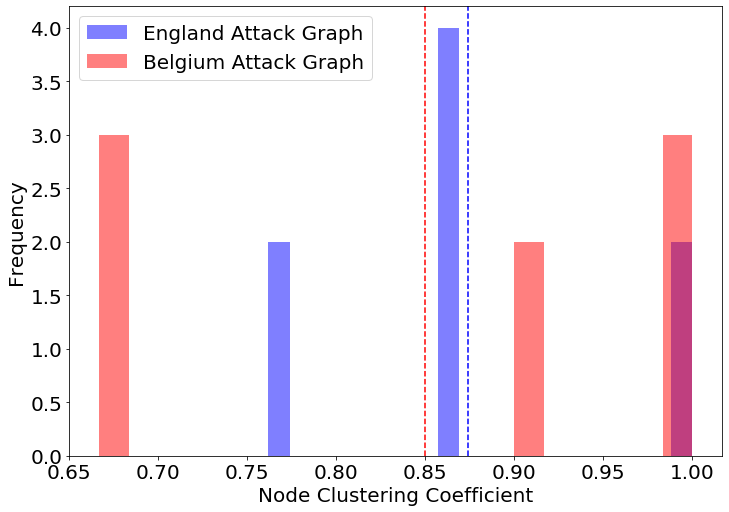

In [68]:
#eng_attack_graph
#bel_attack_graph

clusters_E = list(nx.clustering(eng_attack_graph).values())
avg_cluster_E = sum(clusters_E)/float(no_nodes)
clusters_B = list(nx.clustering(bel_attack_graph).values())
avg_cluster_B = sum(clusters_B)/float(no_nodes)

a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel('Node Clustering Coefficient',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.tick_params(labelsize=20)

plt.hist(clusters_E,bins=20,label="England Attack Graph",alpha=0.5,color='blue')
plt.hist(clusters_B,bins=20,label='Belgium Attack Graph',alpha=0.5,color='red')

plt.axvline(x=avg_cluster_E, linestyle='--', color='blue')
plt.axvline(x=avg_cluster_B, linestyle='--', color='red')

plt.legend(loc='upper centre',fontsize=20)

plt.show()

## Part two - random networks vs match graph comparison

Clustering Coefficient: 0.665539 
Name: 
Type: Graph
Number of nodes: 28
Number of edges: 168
Average degree:  12.0000
cluster coefficient 0.6655394558755904
connectivity 3.0205030071742907
Density 0.4444444444444444
Centrality 0.12620027434842257


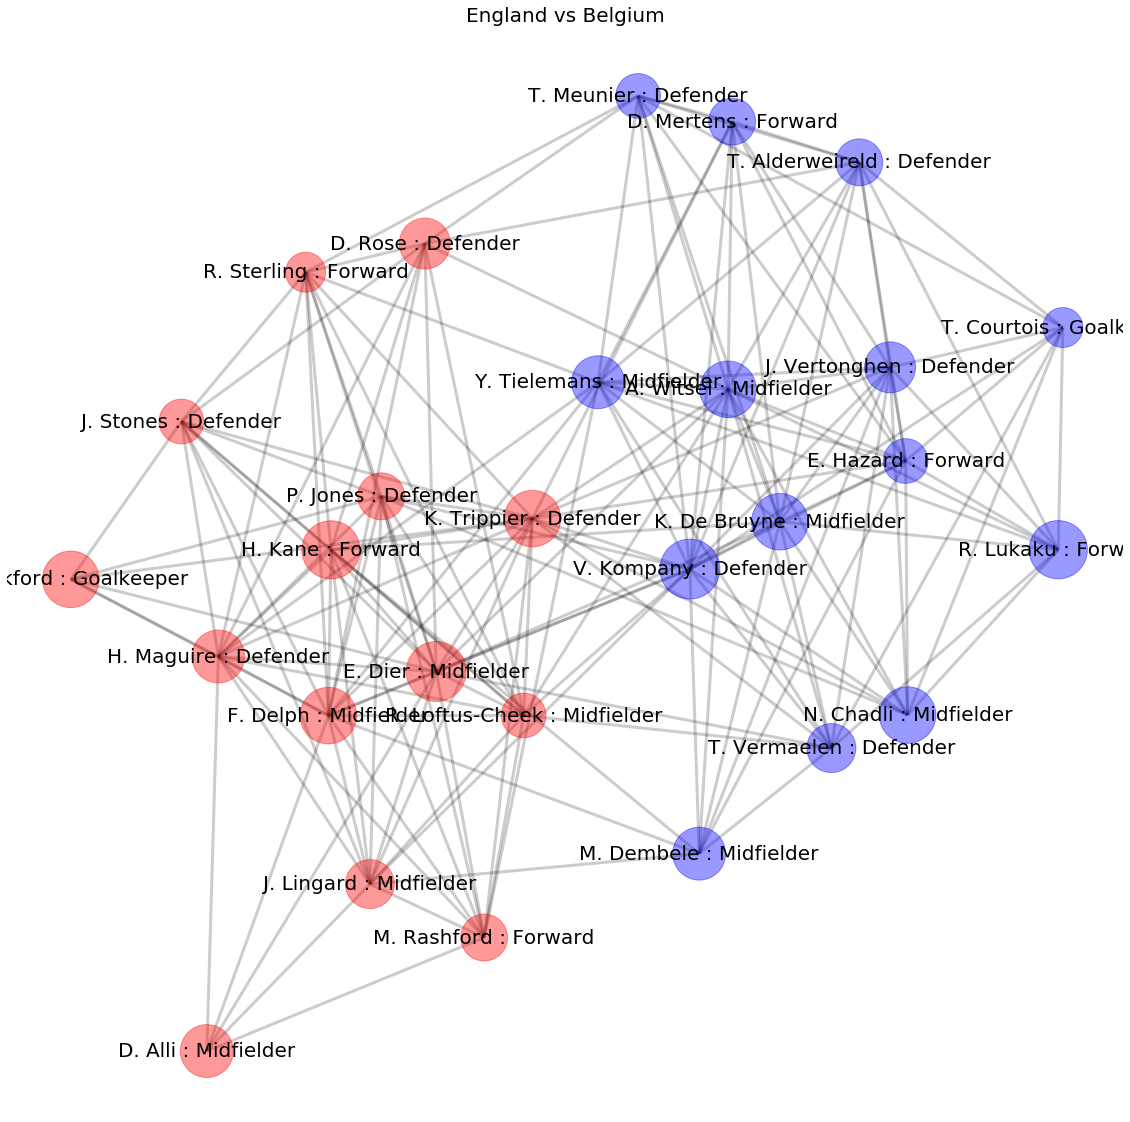

In [69]:
#England vs Belgium match graph
#To get a match graph of England vs Belgium
EngvsBel =create_and_show_graph(events,2058016, 2413,'England', 5629, 'Belgium')

print("Clustering Coefficient: %f "%nx.average_clustering(EngvsBel['graph']))
print(nx.info(EngvsBel['graph']))

#Network statistics of eng vs bel graph    
print("cluster coefficient",nx.average_clustering(EngvsBel['graph']))
print("connectivity",nx.algebraic_connectivity(EngvsBel['graph']))
print("Density",nx.density(EngvsBel['graph']))
print("Centrality",nx.global_reaching_centrality(EngvsBel['graph']))

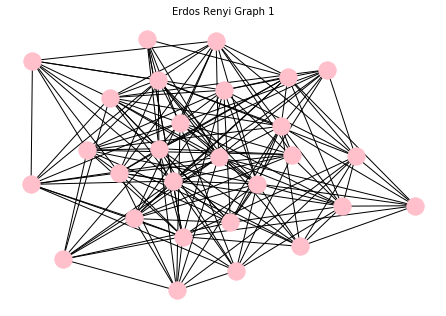

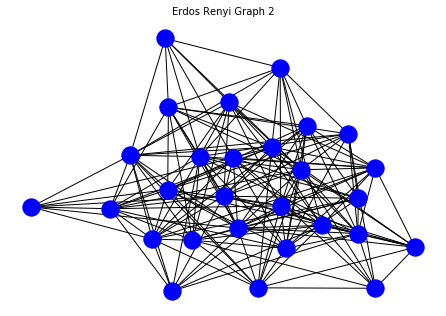

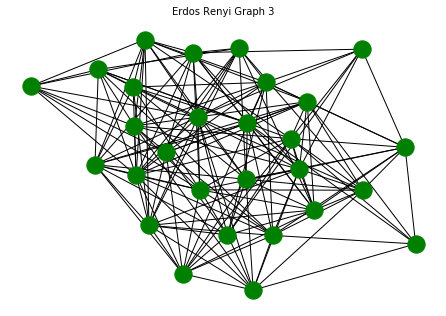

Name: 
Type: Graph
Number of nodes: 28
Number of edges: 163
Average degree:  11.6429
Clustering Coefficient 1: 0.413221 
Name: 
Type: Graph
Number of nodes: 28
Number of edges: 173
Average degree:  12.3571
Clustering Coefficient 2: 0.481463 
Name: 
Type: Graph
Number of nodes: 28
Number of edges: 165
Average degree:  11.7857
Clustering Coefficient 3: 0.431949 
0.442210833439825
167.0


In [70]:
#Erdos renyi Graph
#Erdos renyi graph 1
edos1=nx.erdos_renyi_graph(28,0.44)
nx.draw(edos1,with_labels=False,node_color='pink')
plt.title("Erdos Renyi Graph 1",fontsize=10)
plt.show()
#Erdos renyi graph 2
edos2=nx.erdos_renyi_graph(28,0.44)
nx.draw(edos2,with_labels=False,node_color='blue')
plt.title("Erdos Renyi Graph 2",fontsize=10)
plt.show()
#Erdos renyi graph 3
edos3=nx.erdos_renyi_graph(28,0.44)
nx.draw(edos3,with_labels=False,node_color='green')
plt.title("Erdos Renyi Graph 3",fontsize=10)
plt.show()

print(nx.info(edos1))
print("Clustering Coefficient 1: %f "%nx.average_clustering(edos1))

print(nx.info(edos2))
print("Clustering Coefficient 2: %f "%nx.average_clustering(edos2))

print(nx.info(edos3))
print("Clustering Coefficient 3: %f "%nx.average_clustering(edos3))

#To take the average 
edges_edos1=edos1.number_of_edges()
edges_edos2= edos2.number_of_edges()
edges_edos3=edos3.number_of_edges()

avg_edges =(edges_edos1+edges_edos2+edges_edos3)/3

avg_cluster_edos = (nx.average_clustering(edos1)+nx.average_clustering(edos2)+nx.average_clustering(edos3))/3
print(avg_cluster_edos)
print(avg_edges)

### Task 1 - Differences between path length and clustering coefficients

For Tasks 1 to 3 below, compare your network to 3 generated random networks (Erdos-Renyi or any other) 
based on the statistics of your dataset, i.e. you will need to maintain the same number of nodes and edges
(or very close to) as the original dataset.  In answering/doing the below analysis, 
you should perform the task on your dataset and the 3 generated networks 
(the presented results should be the average seen across these 3).
Task 1. What are the differences between path length and clustering coefficients? 

In [71]:
#To get  cluster coefficients
no_nodes =28
clusters_engvsbel = list(nx.clustering(EngvsBel['graph']).values())
avg_cluster_engvsbel = sum(clusters_engvsbel)/float(no_nodes)



# Average of 3 radnom erdos reny graph : avg_cluster_edos
print(" England vs Belgium match average cluster coefficient is ",avg_cluster_engvsbel)
print(" Erdos renyi 3 random graphs average cluster coefficient is ",avg_cluster_edos)

 England vs Belgium match average cluster coefficient is  0.6655394558755904
 Erdos renyi 3 random graphs average cluster coefficient is  0.442210833439825


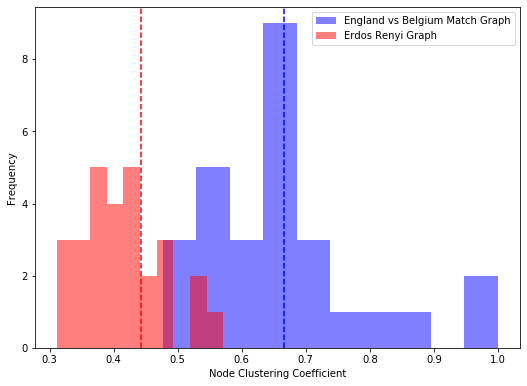

In [72]:
# Cluster coefficient graph 

cluster_edos=list(nx.clustering(edos1).values())
a4_dims = (8.7, 6.27)

fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel('Node Clustering Coefficient',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.tick_params(labelsize=10)

plt.hist(clusters_engvsbel,bins=10,label="England vs Belgium Match Graph",alpha=0.5,color='blue')
plt.hist(cluster_edos,bins=10,label='Erdos Renyi Graph',alpha=0.5,color='red')

plt.axvline(x=avg_cluster_engvsbel, linestyle='--', color='blue')
plt.axvline(x=avg_cluster_edos, linestyle='--', color='red')

plt.legend(loc='upper right',fontsize=10)

plt.show()

In [73]:
#Path length
def get_path_lengths(graph):
    lengths = []
    for i in range(28):
        for j in range(i):
            lengths.append(len(nx.shortest_path(graph,i,j))-1)
    return lengths

path_lengths_edos1=get_path_lengths(edos1)
path_lengths_edos2=get_path_lengths(edos2)
path_lengths_edos3=get_path_lengths(edos3)

In [74]:
#path length for EngvsBel
def get_path_lengths(G):
    lengths = []
    all_nodes= list(G.nodes())
    for i in range (len(all_nodes)):
        for j in range(i):
            lengths.append(len(nx.shortest_path(G,all_nodes[i],all_nodes[j]))-1)
    return lengths

path_lengths_EngvsBel = get_path_lengths(EngvsBel['graph'])
print(path_lengths_EngvsBel)
avg_path_EngvsBel = sum(path_lengths_EngvsBel)/float(len(path_lengths_EngvsBel))
print(avg_path_EngvsBel)

[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 3, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 2, 3, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 3, 2, 2, 2, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 1, 3, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 

In [75]:
#Erdos renyi graph : edos1=nx.erdos_renyi_graph(28,0.44)
#EngvsBel graph : EngvsBel['graph']

print(nx.average_shortest_path_length(EngvsBel['graph']))
print(nx.average_shortest_path_length(edos1))
print(nx.average_shortest_path_length(edos2))
print(nx.average_shortest_path_length(edos3))
avg_edos_shortest_path_length = (nx.average_shortest_path_length(edos1)+nx.average_shortest_path_length(edos2)+nx.average_shortest_path_length(edos3))/3
print(avg_edos_shortest_path_length)

1.6084656084656084
1.5714285714285714
1.5423280423280423
1.5687830687830688
1.560846560846561


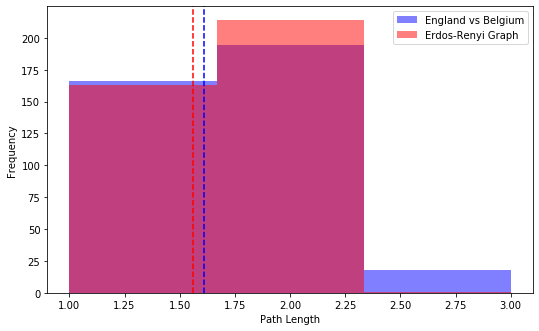

In [76]:
a4_dims = (8.7, 5.27)

fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel('Path Length',fontsize=10)
plt.ylabel('Frequency',fontsize=10)

plt.hist(path_lengths_EngvsBel,bins=3,label="England vs Belgium",alpha=0.5,color='blue')
plt.hist(path_lengths_edos1,bins=3,label='Erdos-Renyi Graph',alpha=0.5,color='red')

plt.axvline(x=avg_path_EngvsBel, linestyle='--', color='blue')
plt.axvline(x=avg_edos_shortest_path_length, linestyle='--', color='red')

plt.legend(loc='upper right',fontsize=10)

plt.show()

In [77]:
#network statistics of erdos-renyi graph

gd_edos1= nx.degree(edos1) 
edos1_dic = dict(gd_edos1)
sum_edos1=np.sum(list(edos1_dic.values()))
average_nodedegree_edos1 = sum_edos1/float(len(edos1.nodes()))

gd_edos2= nx.degree(edos2) 
edos2_dic = dict(gd_edos2)
sum_edos2=np.sum(list(edos2_dic.values()))
average_nodedegree_edos2 = sum_edos2/float(len(edos2.nodes()))

gd_edos3= nx.degree(edos3) 
edos3_dic = dict(gd_edos3)
sum_edos3=np.sum(list(edos3_dic.values()))
average_nodedegree_edos3 = sum_edos3/float(len(edos3.nodes()))


average_nodedegree=(average_nodedegree_edos1+average_nodedegree_edos2+average_nodedegree_edos3)/3
cluster_coefficient = (nx.average_clustering(edos1)+nx.average_clustering(edos2)+nx.average_clustering(edos3))/3
connectivity =(nx.algebraic_connectivity(edos1)+nx.algebraic_connectivity(edos2)+nx.algebraic_connectivity(edos3))/3
density = (nx.density(edos1)+nx.density(edos2)+nx.density(edos3))/3
centrality =(nx.global_reaching_centrality(edos1)+nx.global_reaching_centrality(edos2)+nx.global_reaching_centrality(edos3))/3


print("cluster coefficient", cluster_coefficient)
print("connectivity", connectivity)
print("Density",density)
print("Centrality",centrality)
print("Average Node degree",average_nodedegree)

cluster coefficient 0.442210833439825
connectivity 5.827961902035471
Density 0.4417989417989418
Centrality 0.09785093735711019
Average Node degree 11.928571428571429


# Task 2 - Robustness comparison

Task 2. Which is more robust? To do this, you should remove edges based on tie strength (weak/strong) or some other measure (edge weight), or remove nodes (e.g. based on node degree), and plot what happens to the size of the giant component as you remove more and more edges/nodes.

Numbers of nodes:  28
Number of edges:  168


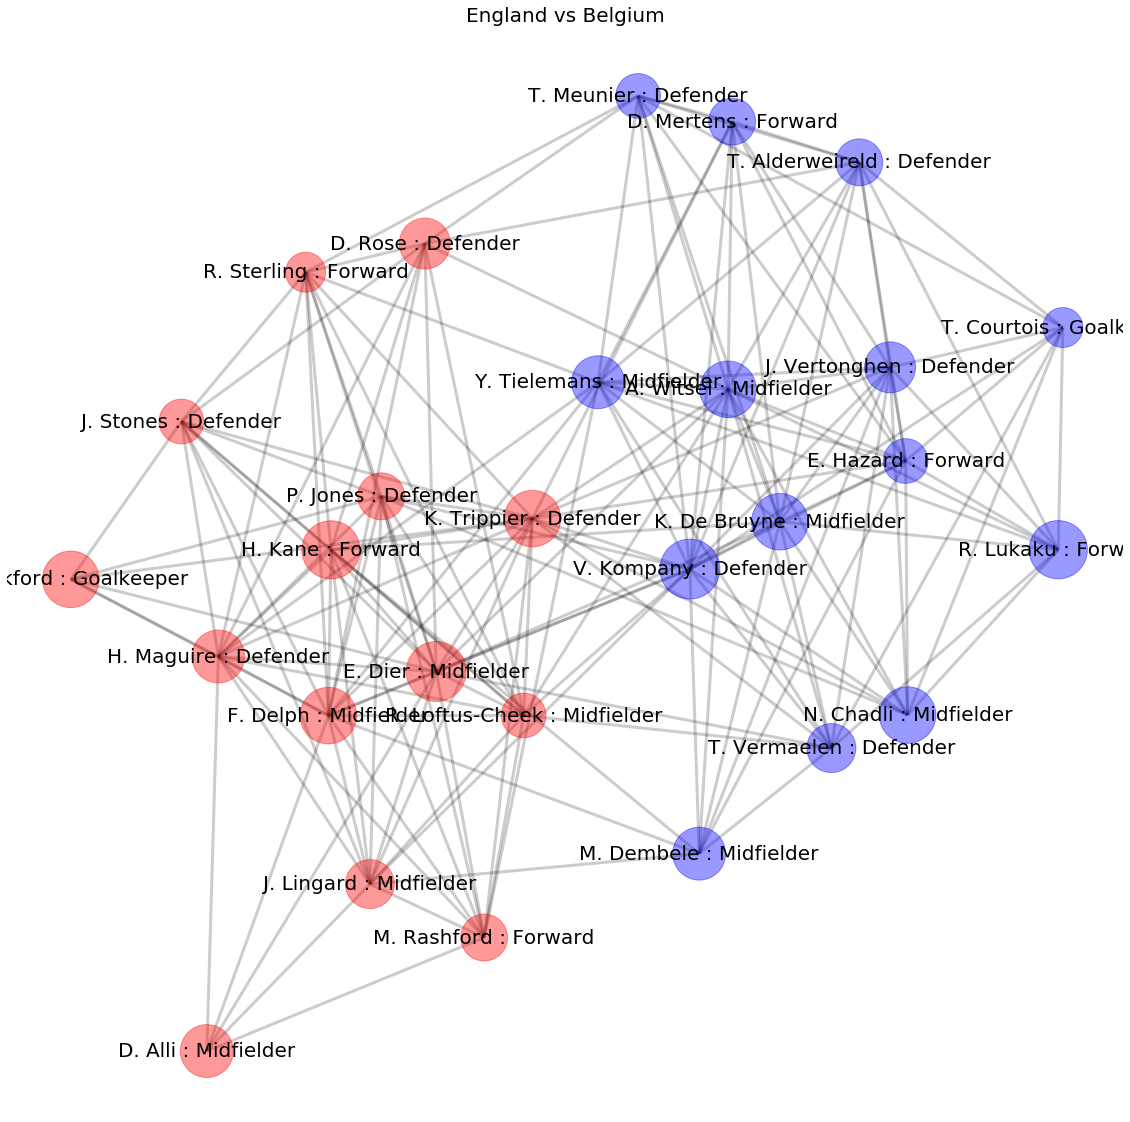

In [79]:
# Graph to use
engVsBel = create_and_show_graph(events,2058016, 2413,'England', 5629, 'Belgium')
engVsBel = engVsBel['graph']
print('Numbers of nodes: ',engVsBel.number_of_nodes())
print('Number of edges: ',engVsBel.number_of_edges())

In [80]:
# Function to find the giant component in Graph

def giant_component(G):
    largest_components= max(nx.connected_components(G), key=len)
    giant_comp_graph = (G).subgraph(largest_components) 

    #draw graph
#     a4_dims = (20, 20)
#     fig, ax = plt.subplots(figsize=a4_dims)
#     ax.set_axis_off()
#     pos = nx.kamada_kawai_layout(giant_comp)
#     nx.draw_networkx_edges(giant_comp_graph, pos, with_labels=False,edge_color="pink", width=6.0)
#     nx.draw_networkx_nodes(giant_comp_graph, pos, node_color='red', alpha=0.4, with_labels=False)
#     nx.draw_networkx_edges(giant_comp_graph, pos, with_labels=False,alpha=0.2,width=3)

    return giant_comp_graph

In [81]:
# Function to plot giant component number of nodes vs giant component size

def giant_component_sizes(G):
    giant_component_sizes = {}
    no_of_nodes_removed = 0
    original_no_nodes= G.number_of_nodes()
    original_largest_component_size = (giant_component(G)).size()
    
    while G.number_of_nodes() > 0:

        #get giant component size and save it
        giant_component_graph= giant_component(G)
        component_size = giant_component_graph.size()
        fraction_of_nodes_removed = no_of_nodes_removed/original_no_nodes
        giant_component_sizes[fraction_of_nodes_removed]=component_size/original_largest_component_size

        # get node with highest degree
        degrees=nx.degree(G)
        highest_degree_node = max(degrees, key=lambda x: x[1])
        # remove the highest degree node
        G.remove_node(highest_degree_node[0])
        no_of_nodes_removed = no_of_nodes_removed+1
    
    return giant_component_sizes

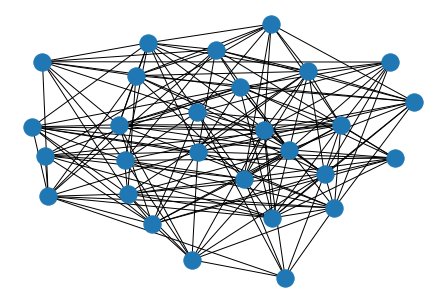

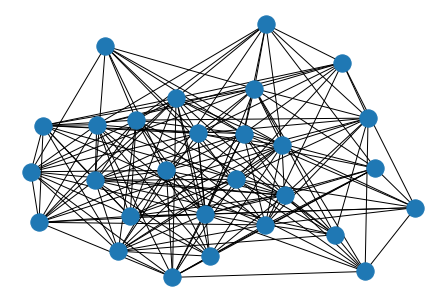

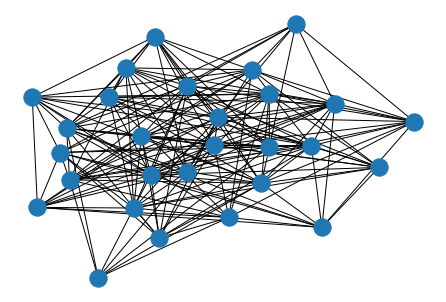

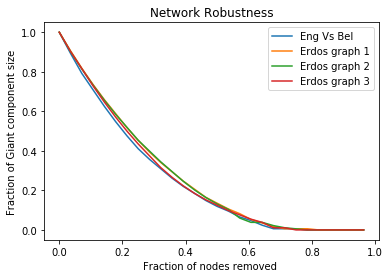

In [82]:
# England VS Belgium
engVsBel_component_sizes = giant_component_sizes(engVsBel)

# Creating all Random graphs and getting their giant component sizes

#Erdos Renyi Graph 1
edos1= nx.erdos_renyi_graph(28,0.44)
nx.draw(edos1, with_labels=False)
plt.show()
erdos1_component_sizes = giant_component_sizes(edos1)

#Erdos Renyi Graph 2
edos2= nx.erdos_renyi_graph(28,0.44)
nx.draw(edos2, with_labels=False)
plt.show()
erdos2_component_sizes = giant_component_sizes(edos2)

#Erdos Renyi Graph 3
edos3= nx.erdos_renyi_graph(28,0.44)
nx.draw(edos3, with_labels=False)
plt.show()
erdos3_component_sizes = giant_component_sizes(edos3)

plt.plot(list(engVsBel_component_sizes.keys()),list(engVsBel_component_sizes.values()), label = "Eng Vs Bel")
plt.plot(list(erdos1_component_sizes.keys()),list(erdos1_component_sizes.values()), label = "Erdos graph 1")
plt.plot(list(erdos2_component_sizes.keys()),list(erdos2_component_sizes.values()), label = "Erdos graph 2")
plt.plot(list(erdos3_component_sizes.keys()),list(erdos3_component_sizes.values()), label = "Erdos graph 3")



plt.legend()
plt.title('Network Robustness')
plt.ylabel('Fraction of Giant component size')
plt.xlabel('Fraction of nodes removed ')
plt.show()

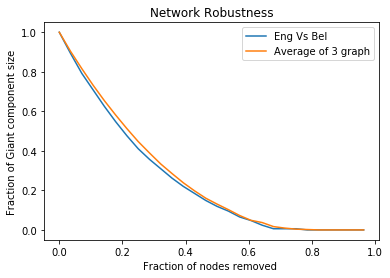

In [83]:
#Average component size values of three random graphs
y=[]
for key in erdos1_component_sizes:
    average_component_size = (erdos1_component_sizes[key] + erdos2_component_sizes[key] + erdos3_component_sizes[key])/3
    y.append(average_component_size)

plt.plot(list(engVsBel_component_sizes.keys()),list(engVsBel_component_sizes.values()), label = "Eng Vs Bel")
plt.plot(list(erdos1_component_sizes.keys()),y, label = "Average of 3 graph")
plt.legend()
plt.title('Network Robustness')
plt.ylabel('Fraction of Giant component size')
plt.xlabel('Fraction of nodes removed ')
plt.show()

# Task 3 PageRank Analysis

Task 3. Calculate the pageranks for the network related to your dataset and the 3 generated random graphs. Compare the pageranks of the dataset network with the average pageranks of the 3 generated random graphs (present and discuss a graph or histogram).

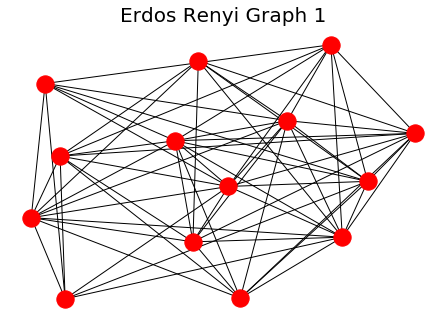

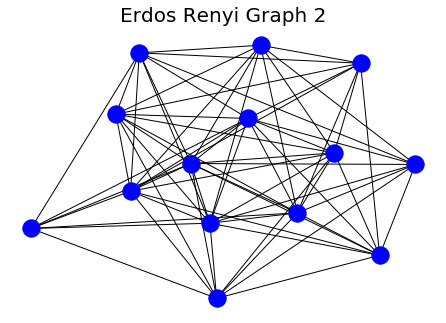

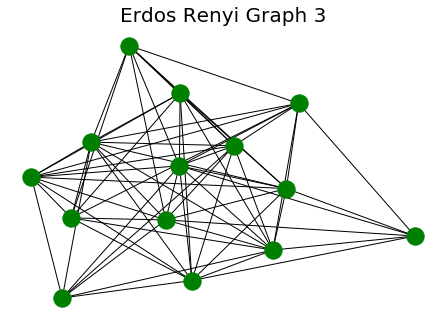

Number of nodes in this graph 1: 14
Number of edges in this graph1 : 64

Number of nodes in this graph 2: 14
Number of edges in this graph 2: 68

Number of nodes in this graph 3: 14
Number of edges in this graph 3 : 65

Number of nodes in the England's graph : 14
Number of edges in the England's graph : 69

Number of nodes in the Belgium's graph : 14
Number of edges in the Belgium's graph : 69

Number of nodes in this Random graphs is: 14
Average NO. of Edges of the Random graphs is: 65


In [84]:
#Erdos renyi Graph for PageRanks

#Erdos renyi graph 1
edos1=nx.erdos_renyi_graph(14,0.75)
nx.draw(edos1,with_labels=False,node_color='red')
plt.title("Erdos Renyi Graph 1",fontsize=20)
plt.show()
#Erdos renyi graph 2
edos2=nx.erdos_renyi_graph(14,0.75)
nx.draw(edos2,with_labels=False,node_color='blue')
plt.title("Erdos Renyi Graph 2",fontsize=20)
plt.show()
#Erdos renyi graph 3
edos3=nx.erdos_renyi_graph(14,0.75)
nx.draw(edos3,with_labels=False,node_color='green')
plt.title("Erdos Renyi Graph 3",fontsize=20)
plt.show()

print("Number of nodes in this graph 1:" ,edos1.number_of_nodes())
print("Number of edges in this graph1 :" ,edos1.number_of_edges())

print("\nNumber of nodes in this graph 2:" ,edos2.number_of_nodes())
print("Number of edges in this graph 2:" ,edos2.number_of_edges())

print("\nNumber of nodes in this graph 3:" ,edos3.number_of_nodes())
print("Number of edges in this graph 3 :" ,edos3.number_of_edges())

print("\nNumber of nodes in the England's graph :" ,eng_graph.number_of_nodes())
print("Number of edges in the England's graph :" ,eng_graph.number_of_edges())

print("\nNumber of nodes in the Belgium's graph :" ,bel_graph.number_of_nodes())
print("Number of edges in the Belgium's graph :" ,bel_graph.number_of_edges())

#To take the average 
edges_edos1=edos1.number_of_edges()
edges_edos2= edos2.number_of_edges()
edges_edos3=edos3.number_of_edges()

avg_edges =int((edges_edos1+edges_edos2+edges_edos3)/3)

print("\nNumber of nodes in this Random graphs is:", edos1.number_of_nodes())
print("Average NO. of Edges of the Random graphs is:",avg_edges)

In [85]:
#Average of the 3 ER graphs' PageRank

Erdos1=nx.pagerank(edos1, alpha=0.9)
Erdos2=nx.pagerank(edos2, alpha=0.9)
Erdos3=nx.pagerank(edos3, alpha=0.9)

result = {key: Erdos1.get(key, 0) + Erdos2.get(key, 0) + Erdos3.get(key, 0) for key in set(Erdos1) | set(Erdos2) | set(Erdos3)}
for key in result:    
    result[key] /=  3
    
result_sort = sorted(result.items(), key=lambda x: x[1], reverse=True)

In [86]:
#Belgium's PageRank

a = nx.pagerank(bel_graph, alpha=0.9)
matchRank_bel = sorted(a.items(), key=lambda x: x[1], reverse=True)

In [87]:
#England's PageRank

a = nx.pagerank(eng_graph, alpha=0.9)
matchRank_eng = sorted(a.items(), key=lambda x: x[1], reverse=True)

In [88]:
#average PageRank of ER graphs

sum1 = 0
avg = 0
for i in range(3):
    edos=(edos1, edos2, edos3)
    a=nx.pagerank(edos[i], alpha=0.9)
    s = sorted(a.items(), key=lambda x: x[1], reverse=True)

    # for k, v in s:
    #     print(k, v)
    #average of pagerank for real AD network
    p=0
    for d in a.values():
        p=p+d
    avg = p/len(a)
    print('Average of pagerank for Edos{}: {}'.format(i, avg))
    sum1 += avg

print("\nAverage PageRank of all the Random Graphs is:{}".format(sum1/3))
edosRank= p/len(a)

Average of pagerank for Edos0: 0.07142857142857144
Average of pagerank for Edos1: 0.07142857142857142
Average of pagerank for Edos2: 0.07142857142857142

Average PageRank of all the Random Graphs is:0.07142857142857142


In [89]:
#England's average PageRank

a=nx.pagerank(eng_graph, alpha=0.9)
s = sorted(a.items(), key=lambda x: x[1], reverse=True)
p=0
for d in a.values():
    p=p+d
print('Average of pagerank for England is: ',p/len(a))

Average of pagerank for England is:  0.07142857142857142


In [90]:
#The most and least influencial players of the England and Belgium respectively.

topRank_bel = nx.get_node_attributes(bel_graph,'shortName')[matchRank_bel[0][0]]
topRank_eng = nx.get_node_attributes(eng_graph,'shortName')[matchRank_eng[0][0]]

botRank_bel = nx.get_node_attributes(bel_graph,'shortName')[matchRank_bel[13][0]]
botRank_eng = nx.get_node_attributes(eng_graph,'shortName')[matchRank_eng[13][0]]

print("The highest ranked player in Belgium is ->", topRank_bel)
print("The lowest ranked player in Belgium is ->", botRank_bel)


print("\nThe highest ranked player in England is ->", topRank_eng)
print("The lowest ranked player in England is ->", botRank_eng)

The highest ranked player in Belgium is -> K. De Bruyne
The lowest ranked player in Belgium is -> M. Dembele

The highest ranked player in England is -> F. Delph
The lowest ranked player in England is -> D. Alli


# Task 4 Cascade


Task 4. [This task has to be conducted on your dataset network only, not on the generated random graphs]. How cascade friendly is your network? Explore 2 different seed nodes (e.g. lowest degree centrality and direct neighbor, a node with average degree centrality and direct neighbor, highest degree centrality and direct neighbor, a random node and direct neighbor), or 2 different fractions of reached/infected nodes, in combination with 2 different thresholds (e.g. 0.1, 0.25, 0.5, 0.75), to determine how information flows/disease spreads through your network. Are there areas which are more likely to cause cascades than others when the initial reached/infected nodes belong to them? You can report the percentage or number of nodes reached/infected for each setting (e.g. table or graph).

In [16]:
# to create a directed graph
def create_and_show_graph(events,matchId, teamOneId,teamOneName, teamTwoId, teamTwoName):
    
    #Only interested in the events which happened in the Cup Final, with matchId 2058017.
    wc_final_events = events[events['matchId']==matchId]
    events = wc_final_events.reset_index(drop=True)
        
    #initialize the graph
    G = nx.DiGraph()
    teamColours = {teamOneId: 'red', teamTwoId: 'blue'}

    #Create Graph
    for i in range(len(events)-1):
        if (events['subEventName'][i]=="Simple pass") and len(events['tags'][i])==1:
            n1, n2 = events['playerId'][i], events['playerId'][i+1]
            p1, p2 = list(players[players['wyId']==n1]['shortName'])[0], list(players[players['wyId']==n2]['shortName'])[0]
            t1, t2 = events['teamId'][i], events['teamId'][i+1]
            r1, r2 = list(players[players['wyId']==n1]['role/name'])[0], list(players[players['wyId']==n2]['role/name'])[0]
            e1, e2 = events['eventSec'][i], events['eventSec'][i+1]
            t = events['tags'][i]
            if n1 not in G.nodes():
                G.add_node(n1, teamid=t1, role=r1, color=teamColours[t1], shortName=p1)
            if n2 not in G.nodes():
                G.add_node(n2, teamid=t2, role=r2, color=teamColours[t2], shortName=p2)
            if any([row['id']==1801 for row in t]):
                G.add_edge(n1,n2, weight=e1)

                
    
                
    #add graph node attributes
    player_information = {}

    for n in G.nodes():
        playerName = nx.get_node_attributes(G,'shortName')[n]
        playerRole = nx.get_node_attributes(G, 'role')[n]
        player_information[n] = (playerName + ' : ' + playerRole).encode().decode('unicode_escape')

    
    e_labels = nx.get_edge_attributes(G,'weight')

    #Create graph nodes list
    teamOneNodes = [n for (n, team) in nx.get_node_attributes(G,"teamid").items() if team == teamOneId]
    teamTwoNodes = [n for (n, team) in nx.get_node_attributes(G,"teamid").items() if team == teamTwoId]

    matchDegree = nx.degree(G)
    #Show graph
    a4_dims = (50, 50)
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_axis_off()

    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=teamOneNodes, node_color='red', alpha=0.4, labels=player_information, with_labels=True, node_size=[v * 200 for v in dict(matchDegree).values()])
    nx.draw_networkx_nodes(G, pos, nodelist=teamTwoNodes, node_color='blue', alpha=0.4, labels=player_information, with_labels=True, node_size=[v * 200 for v in dict(matchDegree).values()])
    nx.draw_networkx_edges(G, pos, with_labels=True, alpha=0.2,width=4, edge_labels=e_labels)
    nx.draw_networkx_labels(G, pos, labels= player_information, font_size=20)

    # create folder based on match
    
    rootPath= '/Users/syedanarmeen/Documents/DSMN/'
    folderName = teamOneName + ' vs ' + teamTwoName + ' matchId ' + str(matchId)
    _dir = os.path.join(rootPath, folderName)
    
    # create 'dynamic' dir, if it does not exist
    if not os.path.exists(_dir):
        os.makedirs(_dir)
    
    plt.savefig(_dir + '/match_graph.pdf')
    plt.title(teamOneName + ' vs ' + teamTwoName, fontsize=20)
#     plt.show()
    
    return {'graph':G, 'folderName': _dir}


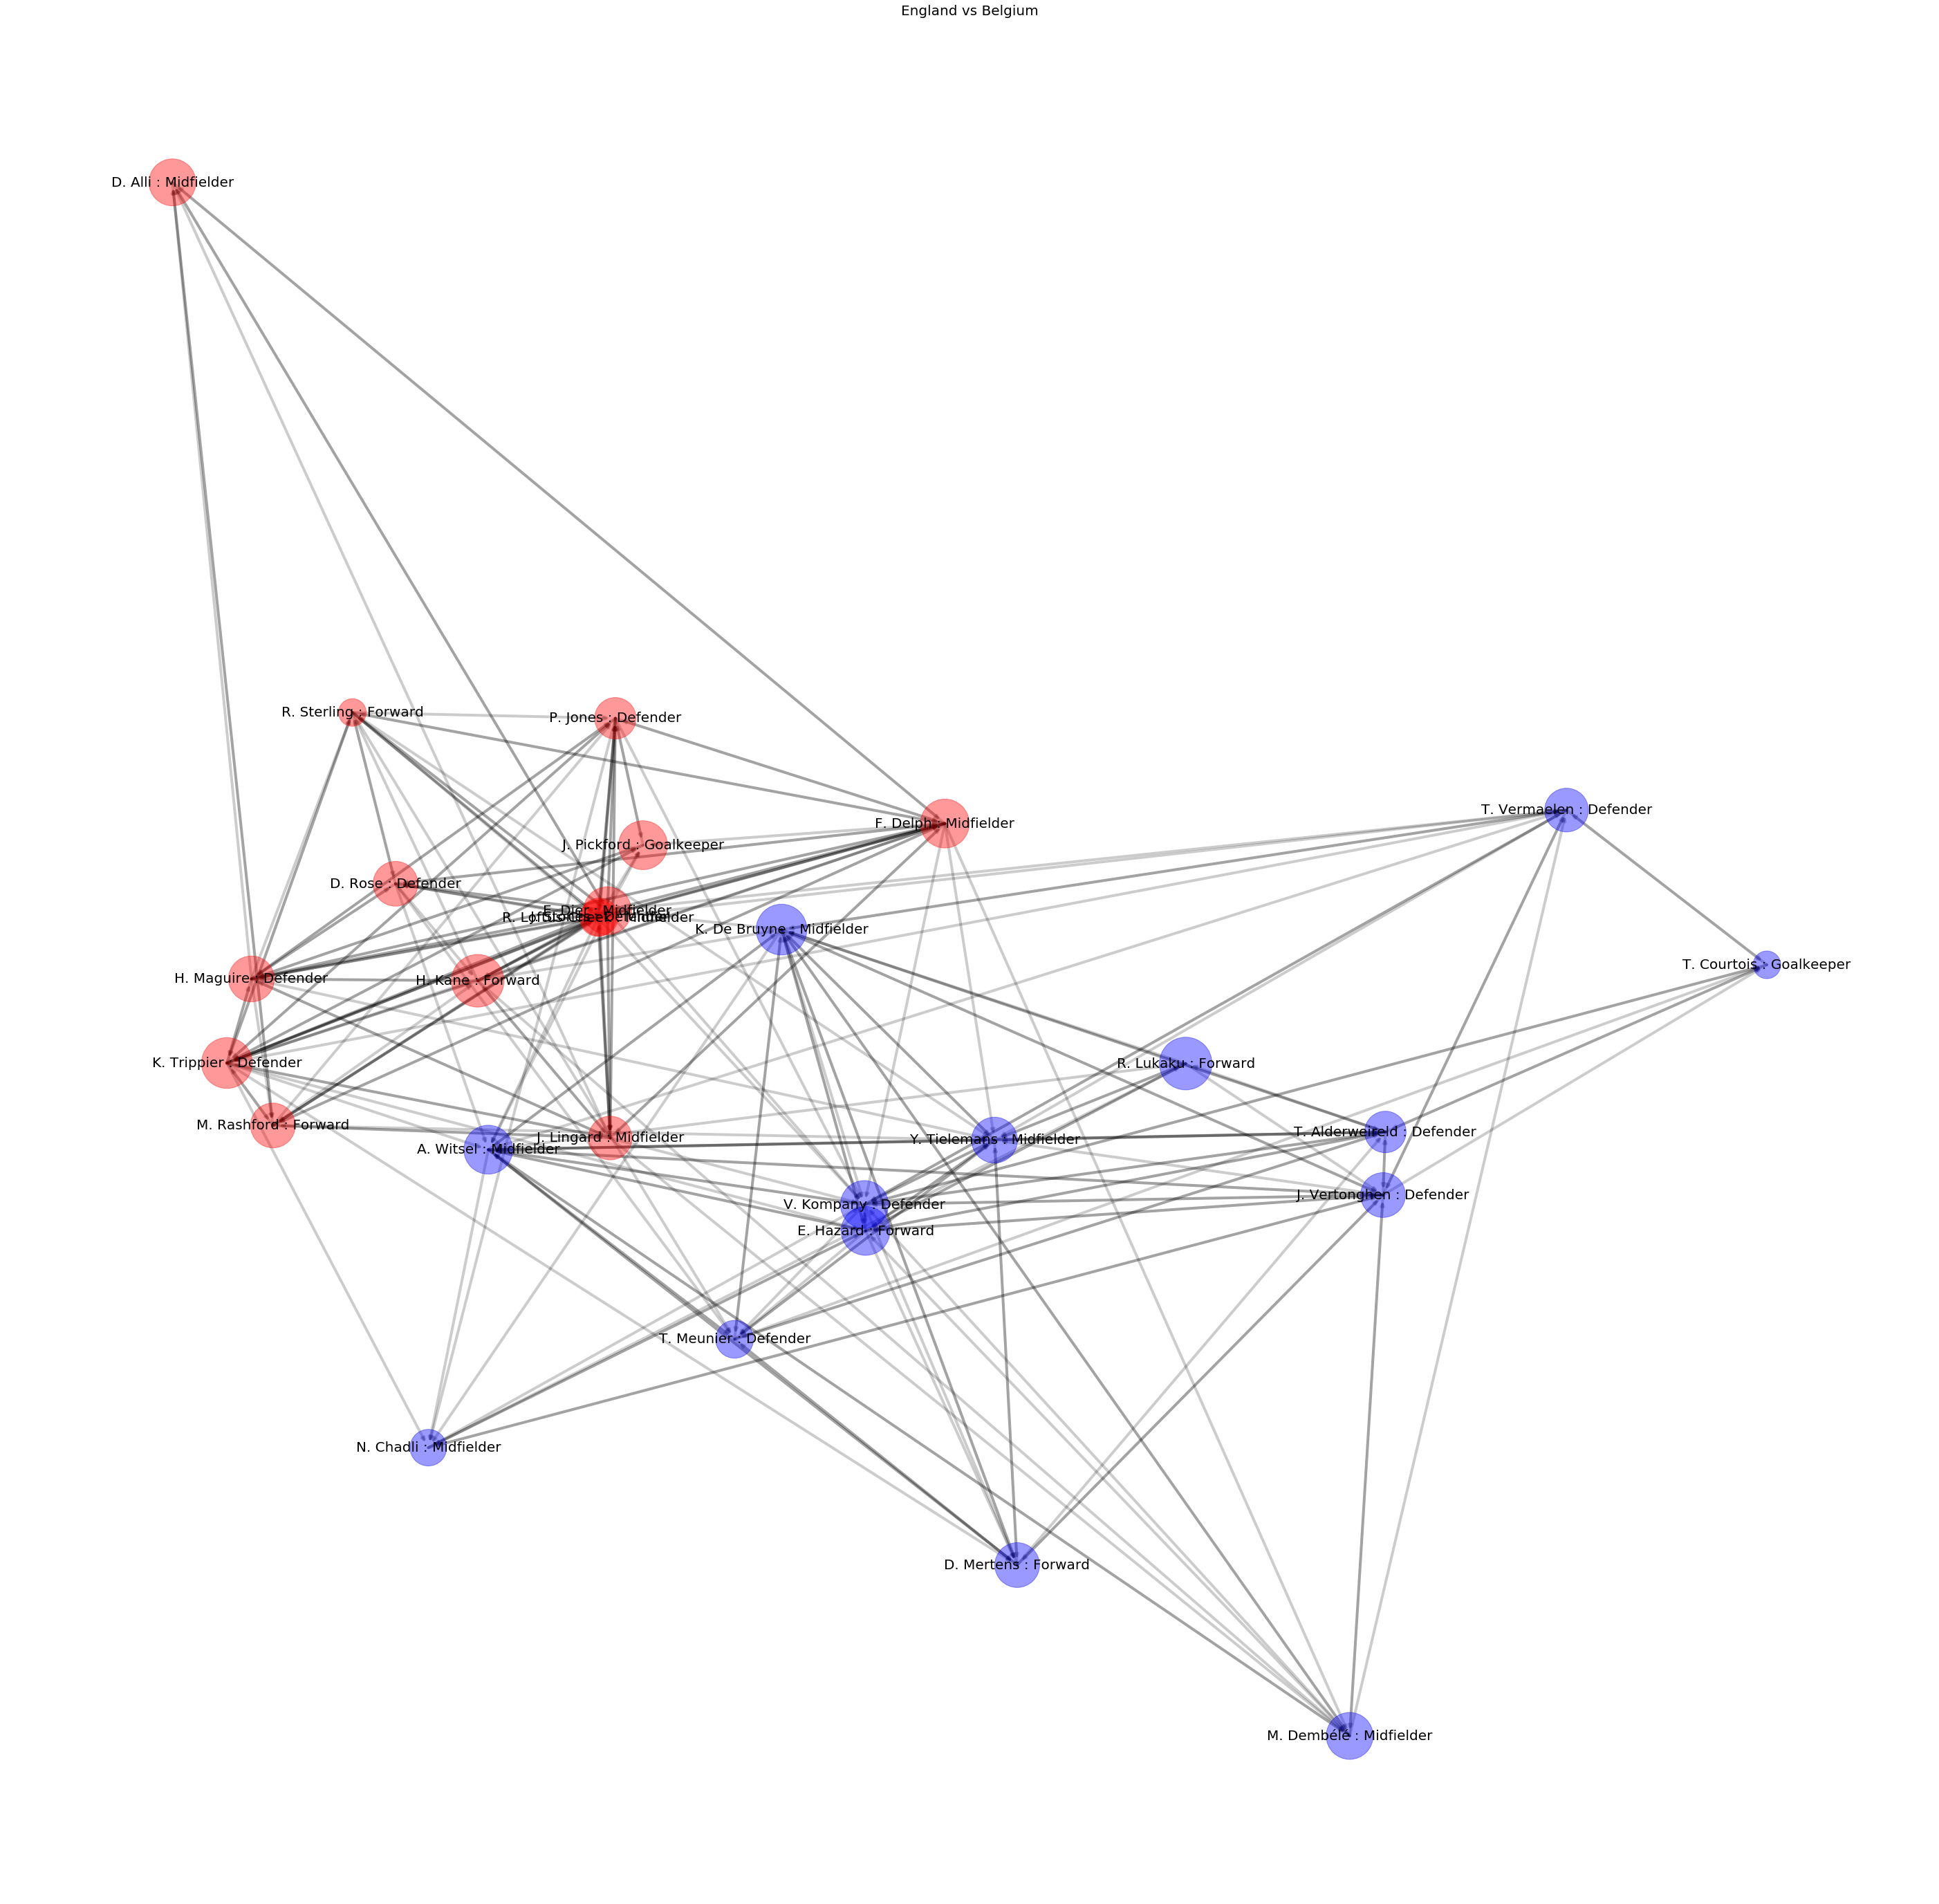

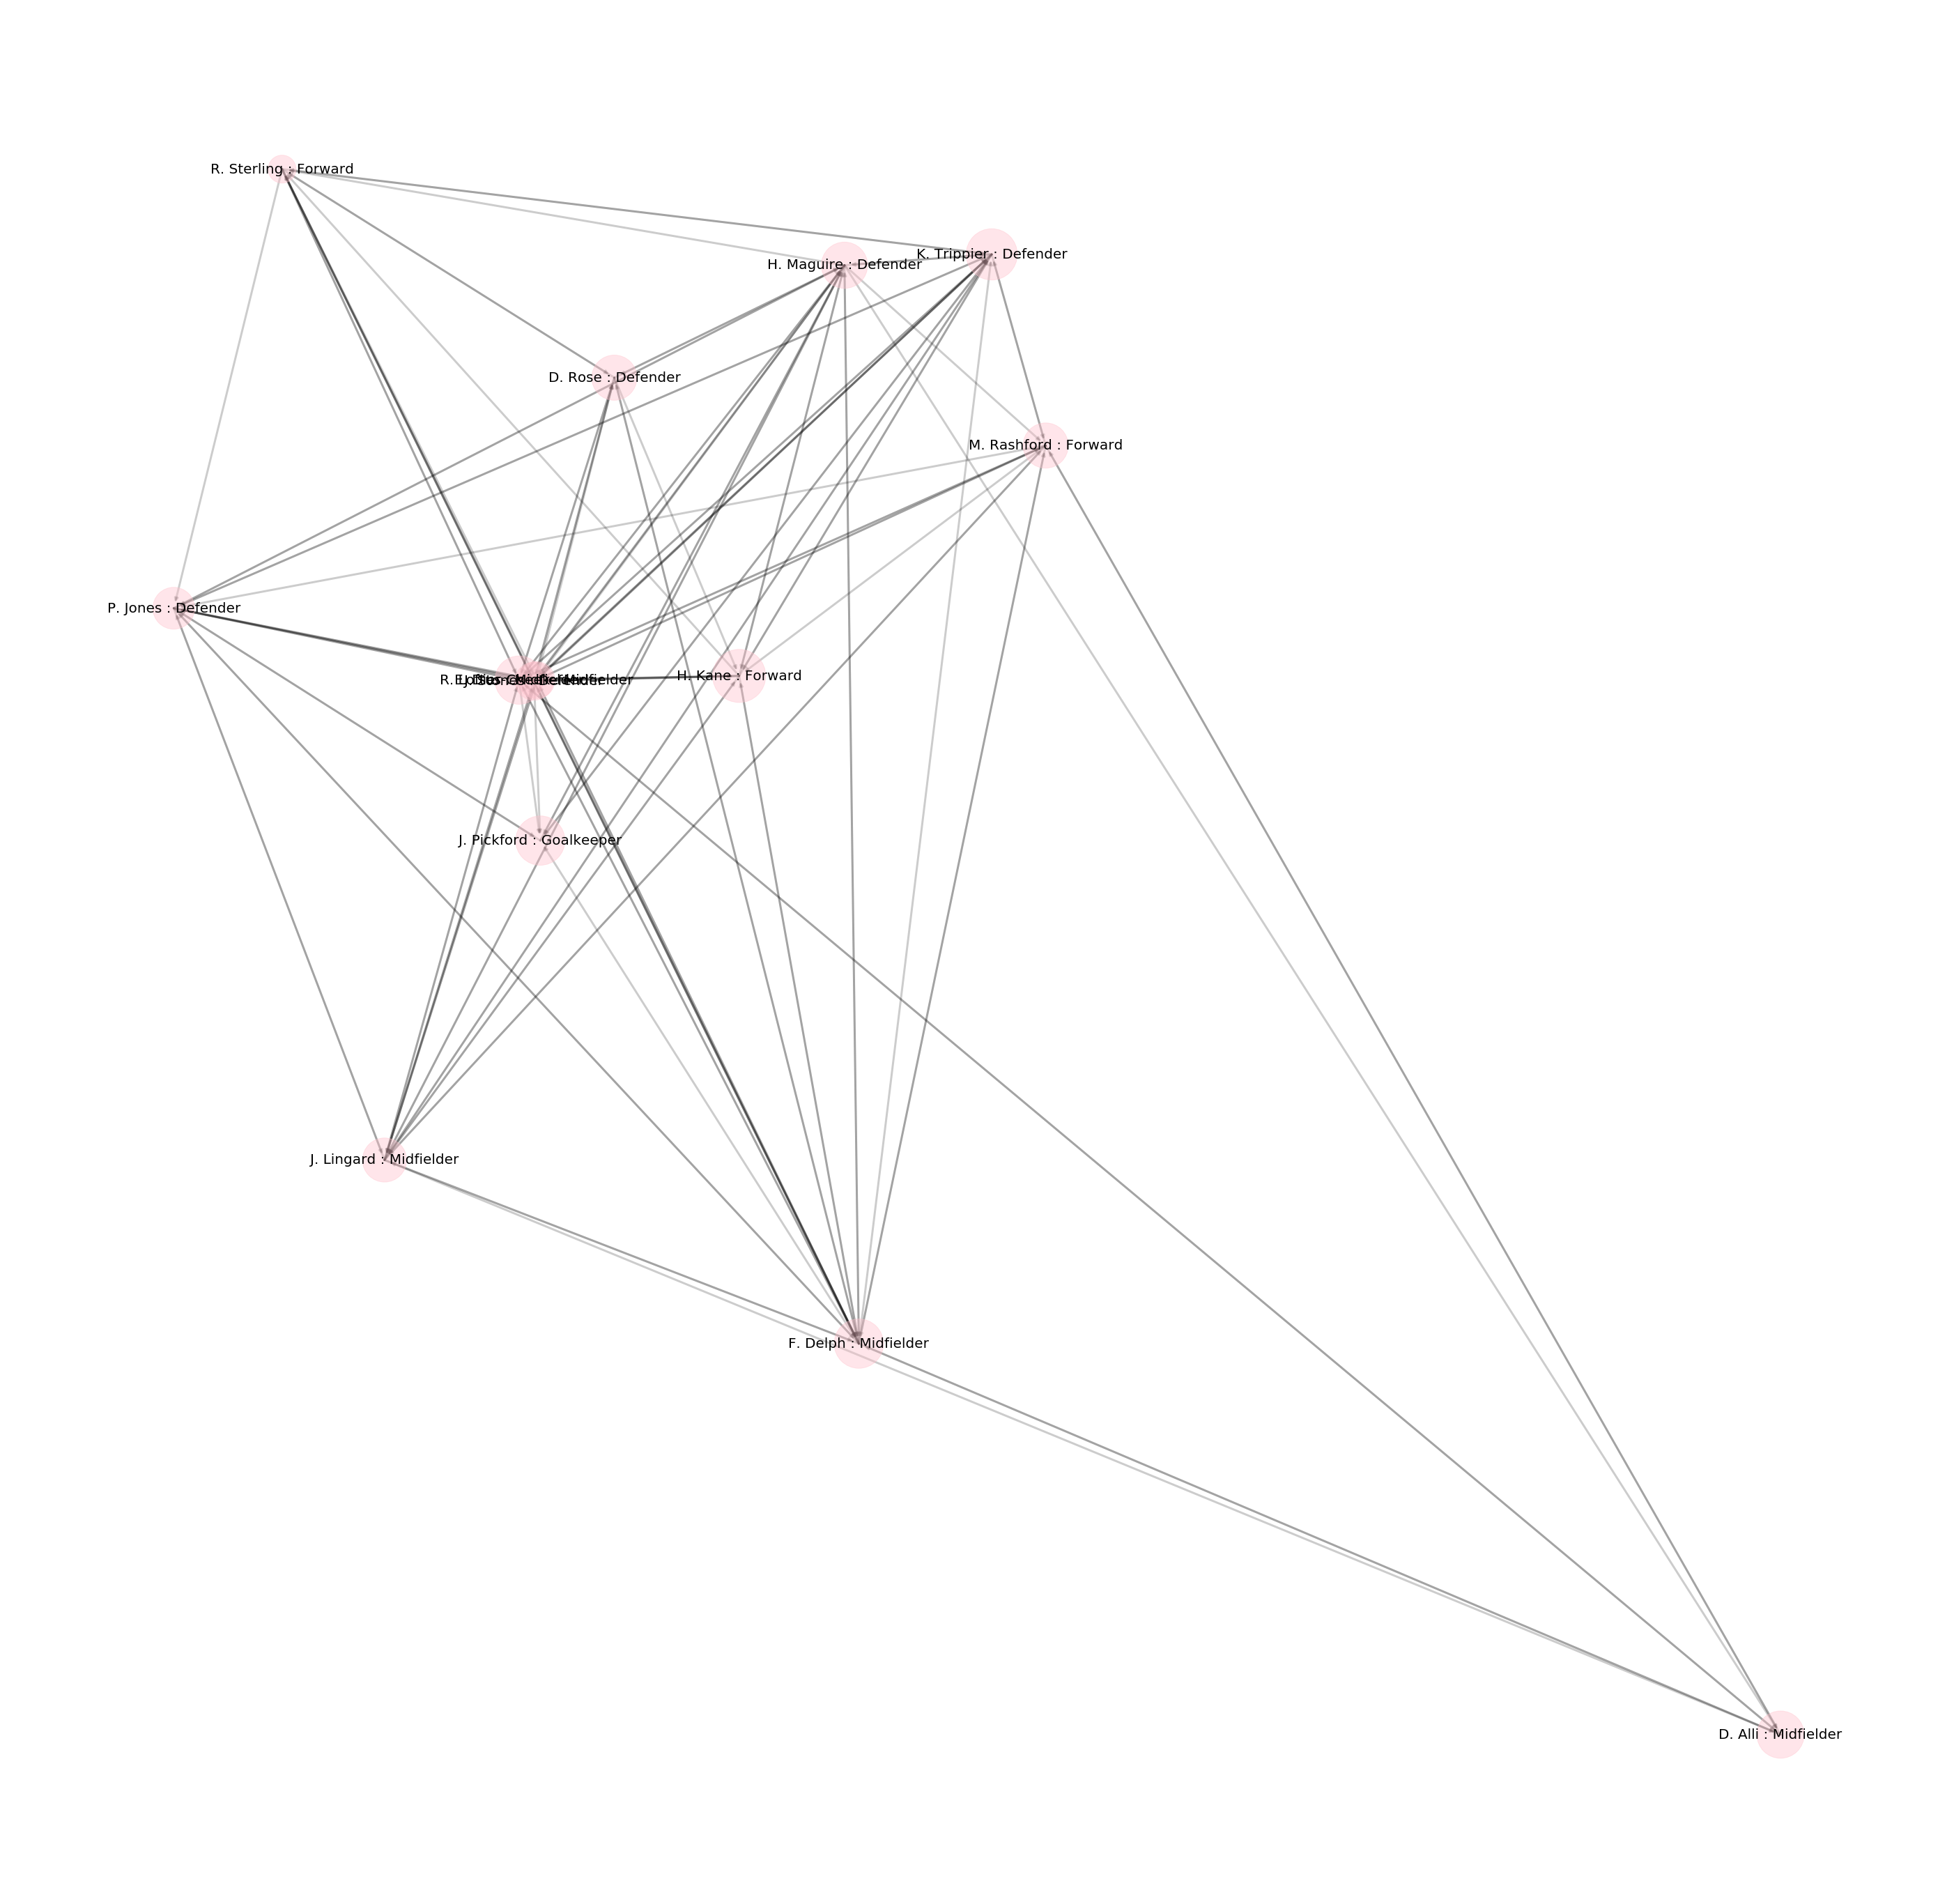

In [19]:
# To get directed graph of england to do manual cascade anaylsis

engVsBel = create_and_show_graph(events,2058016, 2413,'England', 5629, 'Belgium')
engVsBel = engVsBel['graph']

england_nodes = [n for (n,team) in nx.get_node_attributes(engVsBel,"teamid").items() if team == 2413]
england_graph = create_and_show_subgraph(engVsBel,england_nodes,'pink', '/Users/syedanarmeen/Documents/DSMN',('bel_graph'))
